# 增强版LOAD算法优化实验设计与参数估计分析

本notebook实现了增强版LOAD算法（EnhancedPDELOAD）进行最优实验设计：
1. 增强版LOAD算法（EnhancedPDELOAD）进行最优实验设计
2. 贝叶斯参数估计与不确定性量化
3. 精炼与重启机制（消除初始随机性影响）
4. 使用优化得到的观测点进行：
   - 最大似然估计
   - 剖面似然图绘制
   - 预测区间计算

专注于增强版LOAD算法的应用和后续分析。

In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
import torch
import os
import nlopt  # 新增导入nlopt以使用Optimise函数

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from deepxde.nn.pytorch.mionet import MIONetCartesianProd_4I
from deepxde.data.quadruple import QuadrupleCartesianProd_4I3O

warnings.filterwarnings('ignore')
# 添加支持中文的字体
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False
# PDE模型参数
mu1 = 0.0858
tmax = 180
Z = 100
phi = 2 # 噪声标准差
t_initial = 0
TF = tmax
min_int = 10  # 最小间隔
dt = 1

# 设计空间
design_space = np.arange(t_initial, TF + 1, dt)

# 真实参数（用于仿真）
true_params = [0.9142, 10.41]  # mu2, alpha

# 从代码2引入的Optimise函数
def Optimise(fun, θ0, lb, ub):
    def tomax(θ, grad):
        return fun(θ)
    opt = nlopt.opt(nlopt.LN_NELDERMEAD, len(θ0))
    opt.set_max_objective(tomax)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_maxtime(3*60)  # 最大优化时间3分钟
    xopt = opt.optimize(θ0)
    fopt = opt.last_optimum_value()
    return xopt, fopt

class TsPredictor:
    def __init__(self):
        self.tmax = 200
        self.dt = 1
        self.tt = np.arange(0, self.tmax, self.dt)
        self.m = 200
        self.training_data = np.load("./data/Train1005_3000.npz", allow_pickle=True)
        self.testing_data = np.load("./data/Test1005_500.npz", allow_pickle=True)
        self.xt1 = np.load("./data/xt.npz", allow_pickle=True)
        
        self.train_sensor_values1 = self.training_data['sensor_values1'].astype(np.float32)
        self.train_sensor_values2 = self.training_data['sensor_values2'].astype(np.float32)
        self.train_sensor_values3 = self.training_data['sensor_values3'].astype(np.float32)
        self.train_xt = self.xt1['xt'].astype(np.float32)
        self.train_Ts = self.training_data['Ts'].astype(np.float32)
        self.train_fps = self.training_data['fps'].astype(np.float32)
        self.train_lts = self.training_data['ltss'].astype(np.float32)
        self.train_mu1s = self.training_data['mu1s'].astype(np.float32)
        self.train_mu2s = self.training_data['mu2s'].astype(np.float32)
        self.train_alphas = self.training_data['alphas'].astype(np.float32)

        self.test_sensor_values1 = self.testing_data['sensor_values1'].astype(np.float32)
        self.test_sensor_values2 = self.testing_data['sensor_values2'].astype(np.float32)
        self.test_sensor_values3 = self.testing_data['sensor_values3'].astype(np.float32)
        self.test_xt = self.xt1['xt'].astype(np.float32)
        self.test_Ts = self.testing_data['Ts'].astype(np.float32)
        self.test_fps = self.testing_data['fps'].astype(np.float32)
        self.test_lts = self.testing_data['ltss'].astype(np.float32)
        self.test_mu1s = self.testing_data['mu1s'].astype(np.float32)
        self.test_mu2s = self.testing_data['mu2s'].astype(np.float32)
        self.test_alphas = self.testing_data['alphas'].astype(np.float32)

        # 归一化
        self.train_sensor_values1_scale, self.Nt_min, self.Nt_max = self.normalize_global(self.train_sensor_values1)
        self.test_sensor_values1_scale = (self.test_sensor_values1 - self.Nt_min) / (self.Nt_max - self.Nt_min)
        self.train_sensor_values2_scale, self.Fin_min, self.Fin_max = self.normalize_global(self.train_sensor_values2)
        self.test_sensor_values2_scale = (self.test_sensor_values2 - self.Fin_min) / (self.Fin_max - self.Fin_min)
        self.train_sensor_values3_scale, self.Tb_min, self.Tb_max = self.normalize_global(self.train_sensor_values3)
        self.test_sensor_values3_scale = (self.test_sensor_values3 - self.Tb_min) / (self.Tb_max - self.Tb_min)

        self.train_mu1s_scale, self.mu1_min, self.mu1_max = self.normalize_global(self.train_mu1s[:, 0])
        self.test_mu1s_scale = (self.test_mu1s[:, 0] - self.mu1_min) / (self.mu1_max - self.mu1_min)
        self.train_mu2s_scale, self.mu2s_min, self.mu2s_max = self.normalize_global(self.train_mu2s[:, 0])
        self.test_mu2s_scale = (self.test_mu2s[:, 0] - self.mu2s_min) / (self.mu2s_max - self.mu2s_min)
        self.train_alphas_scale, self.alphas_min, self.alphas_max = self.normalize_global(self.train_alphas[:, 0])
        self.test_alphas_scale = (self.test_alphas[:, 0] - self.alphas_min) / (self.alphas_max - self.alphas_min)

        self.train_Ts_scale, self.Ts_min, self.Ts_max = self.normalize_global(self.train_Ts)
        self.train_fps_scale, self.fps_min, self.fps_max = self.normalize_global(self.train_fps)
        self.train_lts_scale, self.lts_min, self.lts_max = self.normalize_global(self.train_lts)
        self.test_Ts_scale = (self.test_Ts - self.Ts_min) / (self.Ts_max - self.Ts_min)
        self.test_fps_scale = (self.test_fps - self.fps_min) / (self.fps_max - self.fps_min)
        self.test_lts_scale = (self.test_lts - self.lts_min) / (self.lts_max - self.lts_min)

        # 转换为张量
        self.train_mu1s_tensor = torch.tensor(self.train_mu1s_scale)
        self.train_mu2s_tensor = torch.tensor(self.train_mu2s_scale)
        self.train_alphas_tensor = torch.tensor(self.train_alphas_scale)
        self.test_mu1s_tensor = torch.tensor(self.test_mu1s_scale)
        self.test_mu2s_tensor = torch.tensor(self.test_mu2s_scale)
        self.test_alphas_tensor = torch.tensor(self.test_alphas_scale)

        self.train_params = torch.stack((self.train_mu1s_tensor, self.train_mu2s_tensor, self.train_alphas_tensor), dim=1)
        self.test_params = torch.stack((self.test_mu1s_tensor, self.test_mu2s_tensor, self.test_alphas_tensor), dim=1)

        self.y_train = torch.cat((torch.from_numpy(self.train_Ts_scale), torch.from_numpy(self.train_fps_scale), torch.from_numpy(self.train_lts_scale)), dim=0).numpy()
        self.y_test = torch.cat((torch.from_numpy(self.test_Ts_scale), torch.from_numpy(self.test_fps_scale), torch.from_numpy(self.test_lts_scale)), dim=0).numpy()

        self.X_train = (self.train_sensor_values1_scale, self.train_sensor_values2_scale, self.train_sensor_values3_scale, self.train_params, self.train_xt)
        self.X_test = (self.test_sensor_values1_scale, self.test_sensor_values2_scale, self.test_sensor_values3_scale, self.test_params, self.test_xt)

        # 模型设置
        data = QuadrupleCartesianProd_4I3O(self.X_train, self.y_train, self.X_test, self.y_test)
        net = MIONetCartesianProd_4I(
            [200, 1024,1024,1024,1024,1024,1024,1024 ,600],
            [200, 1024,1024,1024,1024,1024,1024,1024 ,600],
            [200, 1024,1024,1024,1024,1024,1024,1024 ,600],
            [3,   1024,1024,1024,1024,1024,1024,1024, 600],
            [2,   512,512,512,512,512,512,512, 512,200],
            {"branch1": "relu", "branch2": "relu", "branch3": "relu", "branch4": "relu", "trunk": "relu"},
            "Glorot normal",
            regularization = ["l2", 0.00001]
        )
        self.model = dde.Model(data, net)
        self.model.compile("adam", lr=0.002, decay=("inverse time", 1, 1e-4), metrics=["mean l2 relative error"])
        self.model.restore(os.path.join(os.getcwd(), "training/models1008/mionet_model.ckpt-76000.pt"), device="cuda", verbose=1)

    def normalize_global(self, data, feature_range=(0, 1)):
        min_val, max_val = feature_range
        global_min = np.min(data)
        global_max = np.max(data)
        scale = global_max - global_min or 1
        normalized_data = (data - global_min) / scale * (max_val - min_val) + min_val
        return normalized_data, global_min, global_max

    def inverse_normalize_global(self, normalized_data, global_min, global_max, feature_range=(0, 1)):
        min_val, max_val = feature_range
        scale = global_max - global_min or 1
        original_data = (normalized_data - min_val) / (max_val - min_val) * scale + global_min
        return original_data

    def predict_Ts(self, test_param):
        test_xt = self.test_xt
        self.sensor_values1 = np.array([[(5 - self.Nt_min) / (self.Nt_max - self.Nt_min)] * self.tmax])
        self.sensor_values2 = np.array([[(0.065 - self.Fin_min) / (self.Fin_max - self.Fin_min)] * self.tmax])
        self.sensor_values3 = np.array(np.concatenate([
            np.full(self.m // 4, (295 - self.Tb_min) / (self.Tb_max - self.Tb_min)),
            np.full(self.m // 4, (305 - self.Tb_min) / (self.Tb_max - self.Tb_min)),
            np.full(self.m // 4, (315 - self.Tb_min) / (self.Tb_max - self.Tb_min)),
            np.full(self.m // 4, (325 - self.Tb_min) / (self.Tb_max - self.Tb_min))
        ])).reshape(1, -1)

        self.mu1 = (test_param[0] - self.mu1_min) / (self.mu1_max - self.mu1_min)
        self.mu2 = (test_param[1] - self.mu2s_min) / (self.mu2s_max - self.mu2s_min)
        self.alpha = (test_param[2] - self.alphas_min) / (self.alphas_max - self.alphas_min)
        self.test_param_normalized = np.array([[self.mu1, self.mu2, self.alpha]])

        self.X_pred = (self.sensor_values1, self.sensor_values2, self.sensor_values3, self.test_param_normalized, test_xt)
        self.y_pred = self.model.predict(self.X_pred)
        self.Ts_pred_normalized = self.y_pred[0, :].reshape(self.tmax, self.m)
        Ts_pred = self.inverse_normalize_global(self.Ts_pred_normalized, self.Ts_min, self.Ts_max)
        return Ts_pred[:, -1]

    def Tt(self, test_param1, obs_times):
        """在指定时间获取温度，使用基于参数的缓存"""
        param_key = tuple(np.round(test_param1, 4))  # 四舍五入避免浮点数问题
        if not hasattr(self, 'Tt_cache_dict'):
            self.Tt_cache_dict = {}
        if param_key not in self.Tt_cache_dict:
            Ts_pred = self.predict_Ts(test_param1)
            self.Tt_cache_dict[param_key] = lambda x: np.interp(x, self.tt, Ts_pred)
        return self.Tt_cache_dict[param_key](obs_times)

# 全局预测器实例
global_predictor = TsPredictor()

class DeepLearningPDEModel:
    def __init__(self, mu1, mu2, alpha, tmax, Z):
        self.mu1 = mu1
        self.mu2 = mu2
        self.alpha = alpha
        self.tmax = tmax
        self.Z = Z

    def set_parameters(self, mu2, alpha):
        self.mu2 = max(mu2, 0.01)
        self.alpha = max(alpha, 0.1)

    def solve(self):
        times = np.arange(0, self.tmax + 1, dt)
        pred_params = [self.mu1, self.mu2, self.alpha]
        temperatures = global_predictor.Tt(pred_params, times)
        return times, temperatures

def model_func(params, t_indices):
    mu2, alpha = params
    model = DeepLearningPDEModel(mu1, mu2, alpha, tmax, Z)
    times, Tf_L = model.solve()
    valid_indices = [min(int(i), len(Tf_L) - 1) for i in t_indices]
    return Tf_L[valid_indices]

def generate_data(true_params, design_points, noise_std):
    responses = model_func(true_params, design_points)
    responses += np.random.normal(0, noise_std, size=responses.shape)
    return responses

def compute_gradients(params, t):
    eps = 1e-2
    grad_mu2 = (model_func([params[0] + eps, params[1]], t) - model_func([params[0] - eps, params[1]], t)) / (2 * eps)
    grad_alpha = (model_func([params[0], params[1] + eps], t) - model_func([params[0], params[1] - eps], t)) / (2 * eps)
    return np.array([grad_mu2, grad_alpha])

def check_minimum_distance(new_point, existing_points, min_distance=10.0):
    if len(existing_points) == 0:
        return True
    distances = np.abs(np.array(existing_points) - new_point)
    return np.all(distances >= min_distance)

def get_valid_candidates(design_space, existing_points, min_distance=10.0):
    valid_indices = [i for i, t in enumerate(design_space) if check_minimum_distance(t, existing_points, min_distance)]
    return valid_indices


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 0.309735 s

Restoring model from /home/lab422/422File/Class_2023/zt/2025/Adaptivedesign10/training/models1008/mionet_model.ckpt-76000.pt ...



In [ ]:


import scipy.linalg as sla
from scipy.optimize import differential_evolution

# 更稳健且带缓存的梯度计算
_grad_cache = {}# 全局梯度缓存字典，key: (参数1, 参数2, 设计点), value: 对应梯度
def compute_gradients_enhanced(params, t, eps=1e-4, use_cache=True):
    """
    增强版梯度计算：中心差分 + 缓存 + 自适应步长
    注意：此函数仅计算关于模型参数(mu2, alpha)的梯度，不包括sigma
    
    【修复3】使用自适应步长，避免固定步长在不同量级参数上的数值问题
    """
    global _grad_cache# 引用全局缓存
    # 构建缓存key
    key = (round(float(params[0]),6), round(float(params[1]),6), float(np.atleast_1d(t)[0]))
    if use_cache and key in _grad_cache:# 若缓存存在，直接返回副本（避免修改原缓存）
        return _grad_cache[key].copy()
    
    p = np.asarray(params, dtype=float)# 确保参数为float型numpy数组
    t_arr = np.atleast_1d(t)# 确保设计点为数组（支持单个/多个点输入）
    
    # 中心差分，更精确（比前向差分精度更高，抵消一阶截断误差）
    g = np.zeros((len(t_arr), 2)) # 梯度矩阵：(设计点数量, 参数数量)
    
    for k in range(2):# 遍历2个参数
        # 【修复3】自适应步长：根据参数量级调整，避免固定步长的数值问题
        dp = eps * max(abs(p[k]), 1.0)  # 步长随参数量级缩放
        
        p_plus = p.copy(); p_minus = p.copy()# 复制当前参数
        p_plus[k] += dp; p_minus[k] -= dp # 对第k个参数分别加/减步长
        
        try:
            # 计算参数扰动后的模型输出（中心差分核心）
            f_plus = np.atleast_1d(model_func([p_plus[0], p_plus[1]], t_arr))
            f_minus = np.atleast_1d(model_func([p_minus[0], p_minus[1]], t_arr))
            g[:, k] = (f_plus - f_minus) / (2 * dp)# 中心差分公式
        except Exception as e:
            # 【修复3】改进异常处理：记录警告但不掩盖问题
            print(f"警告：参数 {k} 在中心差分时失败 (参数值={p[k]:.4f}, 步长={dp:.2e}): {str(e)}")
            try:
                # 回退到前向差分
                f_center = np.atleast_1d(model_func([p[0], p[1]], t_arr))
                f_plus = np.atleast_1d(model_func([p_plus[0], p_plus[1]], t_arr))
                g[:, k] = (f_plus - f_center) / dp
                print(f"  -> 已回退到前向差分")
            except Exception as e2:
                print(f"  -> 前向差分也失败: {str(e2)}，使用零梯度")
                g[:, k] = 0  # 最坏情况：使用零梯度
    
    # 若输入单个设计点，返回标量梯度；否则返回矩阵
    grad = g if len(t_arr) > 1 else g[0]
    if use_cache:# 存入缓存
        _grad_cache[key] = grad.copy()
    return grad

def get_valid_candidates_robust(design_space, existing_points, min_distance=10.0):
    """
    更稳健的候选点选择（容差匹配）
    """
    if len(existing_points) == 0:
        return list(range(len(design_space)))
    
    existing = np.array(existing_points, dtype=float)
    tol = 1e-6
    valid_indices = []
    
    for i, t in enumerate(design_space):# 遍历每个候选点
        dmin = np.min(np.abs(existing - t))# 计算与已有点的最小距离
        if dmin + tol >= min_distance:# 容差修正：允许微小偏差（避免因浮点数误差误判无效）
            valid_indices.append(i)
    return valid_indices

class EnhancedPDELOAD:
    """
    """
    def __init__(self, design_space, params_initial, noise_std=2.0, criterion='D',
                min_distance=10.0, prior_cov_scale=5.0, top_k=50, 
                exploration_rate=0.15, adaptive_weights=True, 
                refinement_ratio=0.8):
        self.design_space = np.array(design_space)# 设计空间（候选实验点）
        self.params_initial = np.array(params_initial, dtype=float)# 初始参数猜测(mu2, alpha)
        self.noise_std_initial = noise_std# 观测噪声标准差初始值
        self.criterion = criterion# 最优设计准则（D/A）
        self.min_distance = min_distance # 设计点最小距离约束
        self.n_params = 3  # 参数数量(mu2, alpha, log_sigma) - 统一使用log尺度
        # 构建完整初始参数向量（统一使用log sigma）
        self.params_initial_full = np.append(self.params_initial, np.log(noise_std))
        self.top_k = int(top_k)# Top-K筛选：仅保留梯度最大的K个候选点（降维）
        self.exploration_rate = float(exploration_rate)# epsilon-贪婪的探索概率
        self.adaptive_weights = adaptive_weights# 是否启用策略权重自适应
        self.refinement_ratio = refinement_ratio  # 新增：触发精炼阶段的进度比例
        
        # 贝叶斯先验设置（新增）：高斯先验，量化初始参数不确定性
        self.prior_mean = self.params_initial_full.copy()# 先验均值（包含log_sigma）
        prior_cov_diag = np.array([
            (0.5)**2,      # mu2的先验方差（标准差0.5，基于物理意义）
            (5)**2,     # alpha的先验方差（标准差5，基于物理意义）
            (1.2)**2       # log_sigma的先验方差（标准差1.5，在对数空间具有合理覆盖）
        ])
        self.prior_cov = np.diag(prior_cov_diag)# 先验协方差（尺度控制不确定性）
        self.prior_prec = np.linalg.inv(self.prior_cov)# 先验精度矩阵（协方差的逆）
        
        # 历史记录（新增）：比原版多记录参数估计和不确定性
        self.design_history = [] # 设计点索引历史
        self.ofi_history = []# Fisher信息矩阵历史
        self.params_history = [] # 参数估计历史
        self.uncertainty_history = []# 不确定性（后验协方差迹）历史
        
        # 自适应参数：用于多策略平衡
        self.temperature = 1.0 # softmax采样温度（控制探索随机性）
        self.success_count = {'greedy': 0, 'diverse': 0, 'uncertain': 0, 'random': 0} # 策略成功计数
        self.strategy_weights = {'greedy': 0.5, 'diverse': 0.3, 'uncertain': 0.2, 'random': 0.0} # 初始策略权重
        
        # 预计算优化设计权重
        self.optimal_design = self._compute_enhanced_flod()

    def _neg_log_posterior(self, params, design_points, responses):
        """负对数后验概率
        贝叶斯参数估计的核心目标函数 —— 将「数据似然」与「先验知识」结合，为后续 MAP（最大后验）估计提供基础。
        params现在包含[mu2, alpha, log_sigma] - 统一使用log尺度
        """
        params = np.asarray(params) 
        # 参数约束：mu2, alpha > 0, log_sigma可以为任意实数
        if params[0] <= 0 or params[1] <= 0:
            return np.inf
            
        try:
            mu2, alpha, log_sigma = params[0], params[1], params[2]
            sigma = np.exp(log_sigma)  # 从对数尺度转换
            
            # 似然项（高斯噪声下的对数似然）
            pred = model_func([mu2, alpha], design_points)# 模型预测值
            res = responses - pred# 残差（观测-预测）
            N = len(res) # 样本量
            ll = -0.5 * N * np.log(2 * np.pi * sigma**2) - 0.5 * np.sum(res**2) / (sigma**2)
            
            # 先验项（高斯先验的对数概率）
            diff = params - self.prior_mean# 参数与先验均值的偏差
            lp = -0.5 * diff @ (self.prior_prec @ diff)# 二次型计算（马氏距离）
            
            return -(ll + lp) # 负对数后验（优化时最小化等价于最大化后验）
        except:
            return np.inf

    def estimate_parameters_bayesian(self, design_points, responses):
        """
        贝叶斯参数估计：MAP + 后验协方差
        返回包含log_sigma的完整参数估计和后验协方差（统一使用log尺度）
        """
        if len(design_points) == 0:# 无数据时，返回先验分布
            return self.prior_mean.copy(), self.prior_cov.copy()
        
        # 多起点全局优化：避免局部最优（原版用多初始点但优化器可能局部收敛）
        bounds = [(0.01, 2.0), (1.0, 30.0), (np.log(0.1), np.log(6))]  # mu2, alpha, log_sigma的边界
        
        # 使用差分进化算法作为全局优化器
        try:
            result = differential_evolution(
                self._neg_log_posterior, bounds, # 目标函数（负对数后验）+ 边界
                args=(design_points, responses),# 额外参数（设计点+响应值）
                seed=42, maxiter=300, popsize=15 # 随机种子（可复现）+ 最大迭代 + 种群规模
            )
            # 优化成功则取最优解，失败则回退到先验均值
            map_estimate = result.x if result.success else self.prior_mean.copy()
        except:
            map_estimate = self.prior_mean.copy()
        
        # 计算后验协方差（Laplace近似：用后验模态处的Hessian近似）
        try:
            # 观测Fisher信息矩阵 = 负对数似然的Hessian（此处用梯度外积近似）
            ofi = self.observed_fisher_info_enhanced(design_points, responses, map_estimate)
            post_prec = self.prior_prec + ofi# 后验精度 = 先验精度 + 观测精度
            post_cov = np.linalg.inv(post_prec + 1e-8 * np.eye(self.n_params))
        except:# 计算失败回退到先验协方差
            post_cov = self.prior_cov.copy()
        
        return map_estimate, post_cov# 返回MAP估计 + 后验协方差（量化不确定性）

    def observed_fisher_info_enhanced(self, design_points, responses, params):
        """
        """
        if len(design_points) == 0:# 无数据时返回微小对角阵（避免奇异）
            return np.eye(self.n_params) * 1e-8
        
        mu2, alpha, log_sigma = params[0], params[1], params[2]
        sigma = np.exp(log_sigma)  # 从对数尺度转换为原始尺度
        ofi = np.zeros((self.n_params, self.n_params))
        N = len(design_points)
        
        # 计算残差（用于交叉项）
        pred = model_func([mu2, alpha], design_points)
        residuals = responses - pred
        
        for i, (t, r) in enumerate(zip(np.atleast_1d(design_points), residuals)):# 遍历每个设计点
            grad = compute_gradients_enhanced([mu2, alpha], [t])# 调用增强版梯度计算（带缓存，精度更高）
            
            # 模型参数的Fisher信息（块对角矩阵的左上2×2块）
            ofi[:2, :2] += np.outer(grad, grad) / (sigma**2)# 累加梯度外积/噪声方差
            
            # 【修复1】模型参数与log_sigma的交叉项（考虑小样本效应）
            # 理论: I_{θᵢ,log_σ} = Σₜ rₜ·(∂f/∂θᵢ) / σ²
            # 注意：这里使用实际残差，而非期望（期望在大样本下为0，但小样本不一定）
            ofi[0, 2] += r * grad[0] / (sigma**2)  # I_{μ₂,log_σ}
            ofi[1, 2] += r * grad[1] / (sigma**2)  # I_{α,log_σ}
        
        # 对称性：Fisher信息矩阵是对称的
        ofi[2, 0] = ofi[0, 2]
        ofi[2, 1] = ofi[1, 2]
        
        # log_sigma的Fisher信息（块对角矩阵的右下元素）
        # 理论推导: I_{log_σ,log_σ} = 2N（与设计点无关，仅与样本量相关）
        ofi[2, 2] = 2.0 * N
        
        return ofi

    def _compute_enhanced_flod(self):
        """
        增强版FLOD计算：带正则化与多起点优化，包含log_sigma参数（统一使用log尺度）
        """
        def objective(weights):# 优化目标：最小化负效用（等价于最大化效用）
            weights = np.abs(weights) # 确保权重非负
            weights = weights / (np.sum(weights) + 1e-12)  # 归一化（加微小值防除零）
            
            efi = np.zeros((self.n_params, self.n_params))# 期望Fisher信息矩阵（EFI）
            log_sigma_init = self.params_initial_full[2]  # 初始log_sigma值
            sigma_init = np.exp(log_sigma_init)  # 转换为原始尺度
            for i, t in enumerate(self.design_space):
                grad = compute_gradients_enhanced(self.params_initial, [t])
                # 模型参数的Fisher信息
                efi[:2, :2] += weights[i] * np.outer(grad, grad) / (sigma_init**2)
            # log_sigma的Fisher信息: 与设计点无关，取决于总样本量（添加因子2）
            efi[2, 2] = 2.0 * np.sum(weights)
            
            # 加入先验信息
            efi_regularized = efi + self.prior_prec * 0.1
            
            try:
                if self.criterion == 'D':
                    # 用slogdet替代det：避免大矩阵行列式数值下溢/溢出
                    sign, logdet = np.linalg.slogdet(efi_regularized)
                    return -logdet if sign > 0 else 1e6# 行列式为负时返回大值
                elif self.criterion == 'A':# A准则：最小化EFI逆矩阵的迹
                    return np.trace(np.linalg.inv(efi_regularized + 1e-8 * np.eye(self.n_params)))
            except:
                return 1e6

        n_points = len(self.design_space)# 候选点数量
        
        # 多起点优化（5次尝试，不同初始化策略，避免局部最优）
        best_weights = None
        best_obj = np.inf
        
        for trial in range(5):
            # 不同初始化策略（原版仅用均匀初始化）
            if trial == 0:
                initial = np.ones(n_points) / n_points  # 均匀分布
            elif trial == 1:
                initial = np.random.dirichlet(np.ones(n_points))  # Dirichlet分布
            else:
                # 3. 梯度加权初始化：优先梯度大的点
                grads_norm = []
                for t in self.design_space:
                    g = compute_gradients_enhanced(self.params_initial, [t])
                    grads_norm.append(np.linalg.norm(g))# 梯度范数（信息含量指标）
                grads_norm = np.array(grads_norm)
                probs = grads_norm / (np.sum(grads_norm) + 1e-12)# 梯度加权概率
                initial = probs + 0.1 * np.random.rand(n_points)# 加随机扰动
                initial = initial / np.sum(initial)# 归一化
            
            try:
                # 用L-BFGS-B优化（带边界约束：权重∈[1e-6,1]，避免零权重）
                result = minimize(objective, initial, method='L-BFGS-B', 
                                bounds=[(1e-6, 1)] * n_points)
                # 保留最优结果（目标函数值最小）
                if result.success and result.fun < best_obj:
                    best_obj = result.fun
                    best_weights = np.abs(result.x)
            except:
                continue# 优化失败跳过
        # 若所有尝试失败，回退到均匀权重
        if best_weights is None:
            return np.ones(n_points) / n_points
        
        return best_weights / (np.sum(best_weights) + 1e-12)

    def _strategy_greedy(self, design_points, responses, params_current, valid_indices):
        """贪婪策略：选择信息增益最大的点（统一使用log尺度）"""
        gains = []
        # 当前Fisher信息矩阵
        current_ofi = self.observed_fisher_info_enhanced(design_points, responses, params_current)
        
        for idx in valid_indices:
            t = self.design_space[idx]
            grad = compute_gradients_enhanced([params_current[0], params_current[1]], [t])
            log_sigma = params_current[2]
            sigma = np.exp(log_sigma)  # 转换为原始尺度
            
            # 模型参数的信息增益
            additional_info = np.zeros((self.n_params, self.n_params))
            additional_info[:2, :2] = np.outer(grad, grad) / (sigma**2)# 新增点的信息
            additional_info[2, 2] = 2.0  # log_sigma的信息增益（添加因子2）
            
            try:
                new_ofi = current_ofi + additional_info# 新增后的信息矩阵
                if self.criterion == 'D':
                    # D准则：信息增益 = 新行列式对数 - 原行列式对数
                    sign_old, logdet_old = np.linalg.slogdet(current_ofi + 1e-8 * np.eye(self.n_params))
                    sign_new, logdet_new = np.linalg.slogdet(new_ofi + 1e-8 * np.eye(self.n_params))
                    gain = logdet_new - logdet_old if sign_old > 0 and sign_new > 0 else 0
                else:  # A-optimal# A准则：增益用迹衡量
                    gain = np.trace(np.linalg.solve(new_ofi + 1e-8 * np.eye(self.n_params), 
                                                  additional_info))
            except:
                gain = np.linalg.norm(grad)  # 回退到梯度模长# 计算失败回退到梯度范数（信息含量近似）
            
            gains.append(gain)
        
        return np.array(gains)

    def _strategy_diversity(self, design_points, valid_indices):
        """多样性策略：选择与现有点距离最大的点"""
        if len(design_points) == 0:
            return np.ones(len(valid_indices))
        
        diversity_scores = []
        for idx in valid_indices:
            t = self.design_space[idx]
            min_dist = np.min(np.abs(design_points - t)) # 与现有点的最小距离
            diversity_scores.append(min_dist)# 距离越大，多样性越好
        
        return np.array(diversity_scores)

    def _strategy_uncertainty(self, design_points, responses, params_current, post_cov, valid_indices):
        """不确定性策略：在参数不确定性大的区域选择点（统一使用log尺度）
        优先选择参数不确定性导致预测方差大的点，针对性降低模型不确定性，属于「定向探索」策略"""
        uncertainty_scores = []
        log_sigma = params_current[2]
        sigma = np.exp(log_sigma)  # 转换为原始尺度
        
        for idx in valid_indices:
            t = self.design_space[idx]
            grad = compute_gradients_enhanced([params_current[0], params_current[1]], [t])
            
            # 预测方差：grad^T * post_cov[:2,:2] * grad + sigma²
            # 只考虑模型参数的不确定性
            pred_var = grad @ post_cov[:2, :2] @ grad.T + sigma**2
            uncertainty_scores.append(pred_var)# 方差越大，不确定性越高
        
        return np.array(uncertainty_scores)

    def select_next_design_enhanced(self, design_points, responses):
        """
        增强版设计点选择：多策略集成 + 自适应权重
        """
        # 1. 贝叶斯参数估计（获取当前参数估计与不确定性）
        params_current, post_cov = self.estimate_parameters_bayesian(design_points, responses)
        
        # 2. 获取有效候选点（满足最小距离约束）
        valid_indices = get_valid_candidates_robust(self.design_space, design_points, self.min_distance)
        if not valid_indices:# 无有效点时随机选择
            return np.random.choice(len(self.design_space))
        
        # 3. Top-K筛选（降维：仅保留梯度最大的K个点，减少计算量）
        if len(valid_indices) > self.top_k:
            grad_norms = []
            for idx in valid_indices:
                t = self.design_space[idx]
                grad = compute_gradients_enhanced([params_current[0], params_current[1]], [t])
                grad_norms.append(np.linalg.norm(grad))
            
            # 选择梯度范数最大的top_k个点
            top_indices = np.argsort(grad_norms)[-self.top_k:]
            valid_indices = [valid_indices[i] for i in top_indices]
        
        # 4. 多策略计算得分
        greedy_scores = self._strategy_greedy(design_points, responses, params_current, valid_indices)
        diversity_scores = self._strategy_diversity(design_points, valid_indices)
        uncertainty_scores = self._strategy_uncertainty(design_points, responses, params_current, post_cov, valid_indices)
        random_scores = np.random.rand(len(valid_indices)) # 随机策略得分（纯探索）
        
        # 5. 得分归一化（消除量纲差异，统一到[0,1]区间）
        greedy_scores = (greedy_scores - np.min(greedy_scores)) / (np.max(greedy_scores) - np.min(greedy_scores) + 1e-12)
        diversity_scores = (diversity_scores - np.min(diversity_scores)) / (np.max(diversity_scores) - np.min(diversity_scores) + 1e-12)
        uncertainty_scores = (uncertainty_scores - np.min(uncertainty_scores)) / (np.max(uncertainty_scores) - np.min(uncertainty_scores) + 1e-12)
        
        # 6. 自适应权重调整（根据历史性能动态优化策略权重）
        if self.adaptive_weights and len(self.params_history) > 3:
            # 计算最近3次参数估计的误差（衡量策略效果）
            recent_errors = []
            for i in range(-3, 0):
                if i < len(self.params_history):
                    # 误差 = 当前参数与历史参数的欧氏距离
                    error = np.linalg.norm(self.params_history[i] - params_current)
                    recent_errors.append(error)
            
            if recent_errors:
                improvement = np.mean(recent_errors) # 平均误差（越大说明参数更新越显著）
                # 误差大时增加探索率（需要更多探索），误差小时减少探索率（侧重利用）
                self.exploration_rate = max(0.05, min(0.3, self.exploration_rate * (1 + 0.1 * improvement)))
        
        # 7. 计算综合得分（策略权重加权求和）
        combined_scores = (self.strategy_weights['greedy'] * greedy_scores + 
                          self.strategy_weights['diverse'] * diversity_scores +
                          self.strategy_weights['uncertain'] * uncertainty_scores +
                          self.strategy_weights['random'] * random_scores)
        
        # 8. epsilon-贪婪选择（平衡探索与利用）
        if np.random.rand() < self.exploration_rate:
            # 探索：softmax采样（温度控制随机性，温度越低越集中于高分）
            probs = np.exp(combined_scores / self.temperature)
            probs = probs / np.sum(probs)
            selected_idx = np.random.choice(len(valid_indices), p=probs)
        else:
            # 利用：直接选择综合得分最高的点
            selected_idx = np.argmax(combined_scores)
        
        # 9. 温度衰减（实验后期减少探索随机性）
        self.temperature *= 0.995
        
        return valid_indices[selected_idx]

    def _refine_initial_designs_and_restart(self, m_initial, n_total, true_params):
        """
        【核心修改】精炼初始设计点并重启序贯选择
        
        关键改进：
        1. 删除所有初始随机选择的m_initial个点
        2. 按最优实验设计重新选择m_initial个优化后的初始点
        3. 基于新的初始点，从头重启序贯选择，直到达到n_total
        4. 彻底消除初始随机点的间接影响
        
        """
        print(f"\n{'='*70}")
        print(f"🔄 开始精炼初始设计点并重启序贯选择...")
        print(f"{'='*70}")
        print(f"📊 原始状态:")
        print(f"   • 当前已有设计点数量: {len(self.current_design_points)}")
        print(f"   • 需要删除的初始随机点: {m_initial} 个")
        print(f"   • 需要删除的基于随机点选出的后续点: {len(self.current_design_points) - m_initial} 个")
        print(f"   • 目标总实验数: {n_total}")
        
        # ============ 第1步：删除所有点（包括初始点和基于初始点选出的后续点）============
        print(f"\n🗑️  第1步：清空所有现有设计点...")
        # 清空当前设计点和响应值
        refined_design_points = []
        refined_responses = []
        print(f"   ✓ 已清空所有 {len(self.current_design_points)} 个设计点")
        
        # ============ 第2步：优先使用上一阶段的MAP估计============
        print(f"\n🧮 第2步：确定重启时使用的参数...")
        # 【关键策略】优先使用历史数据的MAP估计，确保算法利用已学到的知识
        # true_params 仅用于生成观测数据（仿真），不用于算法决策
        
        if hasattr(self, 'current_design_points') and len(self.current_design_points) > 0:
            # 优先方案：使用上一阶段的MAP估计
            try:
                map_est, _ = self.estimate_parameters_bayesian(
                    self.current_design_points, 
                    self.current_responses
                )
                current_params = map_est.copy()
                print(f"   ✓ 使用上一阶段的MAP估计: μ₂={current_params[0]:.4f}, α={current_params[1]:.4f}, σ={np.exp(current_params[2]):.4f}")
                if true_params is not None:
                    true_with_noise = np.append(true_params, np.log(self.noise_std_initial))
                    print(f"   📊 参考真实参数: μ₂={true_with_noise[0]:.4f}, α={true_with_noise[1]:.4f}, σ={np.exp(true_with_noise[2]):.4f}")
                    print(f"   📈 估计误差: Δμ₂={abs(current_params[0]-true_with_noise[0]):.4f}, Δα={abs(current_params[1]-true_with_noise[1]):.4f}")
            except Exception as e:
                # 异常处理：回退到先验均值
                current_params = self.prior_mean.copy()
                print(f"   ⚠️  MAP计算失败 ({str(e)})，回退到先验均值")
                print(f"   • 使用先验均值: μ₂={current_params[0]:.4f}, α={current_params[1]:.4f}, σ={np.exp(current_params[2]):.4f}")
        else:
            # 无历史数据：使用先验均值
            current_params = self.prior_mean.copy()
            print(f"   • 无历史数据，使用先验均值: μ₂={current_params[0]:.4f}, α={current_params[1]:.4f}, σ={np.exp(current_params[2]):.4f}")
        
        print(f"   ✓ 参数设置完成，准备进行后续实验设计")
        
        # ============ 第3步：使用当前参数重新计算最优设计权重============
        print(f"\n🎯 第3步：计算基于当前参数的最优设计权重...")
        optimal_weights = self._compute_optimal_weights(current_params)
        print(f"   ✓ 最优权重计算完成")
        print(f"   • Top 5 最优位置（权重最大）: {np.argsort(optimal_weights)[-5:]}")
        
        # ============ 第4步：使用D-optimal准则选择m_initial个新的优化初始点============
        print(f"\n🎲 第4步：重新选择 {m_initial} 个优化后的初始点...")
        new_initial_points = []
        new_initial_responses = []
        temp_design_points = []
        temp_responses = []
        
        for i in range(m_initial):
            # 获取满足最小距离约束的有效候选点
            valid_indices = get_valid_candidates_robust(
                self.design_space, 
                temp_design_points, 
                self.min_distance
            )
            
            if not valid_indices:
                print(f"   ⚠️  第 {i+1}/{m_initial} 个初始点：无满足距离约束的候选点，跳过")
                break
            
            # 计算每个候选点的D-optimal增益
            best_idx = None
            best_gain = -np.inf
            current_ofi = self.observed_fisher_info_enhanced(
                np.array(temp_design_points) if temp_design_points else np.array([]), 
                np.array(temp_responses) if temp_responses else np.array([]), 
                current_params
            )
            
            for idx in valid_indices:
                t = self.design_space[idx]
                grad = compute_gradients_enhanced([current_params[0], current_params[1]], [t])
                log_sigma = current_params[2]
                sigma = np.exp(log_sigma)  # 转换为原始尺度
                additional_info = np.zeros((self.n_params, self.n_params))
                additional_info[:2, :2] = np.outer(grad, grad) / (sigma**2)
                additional_info[2, 2] = 2.0  # log_sigma的信息增益（添加因子2）
                
                try:
                    new_ofi = current_ofi + additional_info
                    # D准则：信息增益 = log(det(new)) - log(det(old))
                    sign_old, logdet_old = np.linalg.slogdet(current_ofi + 1e-8 * np.eye(self.n_params))
                    sign_new, logdet_new = np.linalg.slogdet(new_ofi + 1e-8 * np.eye(self.n_params))
                    
                    if sign_old > 0 and sign_new > 0:
                        gain = logdet_new - logdet_old
                        # 结合最优权重进行调整
                        gain_weighted = gain * (1 + optimal_weights[idx])
                        
                        if gain_weighted > best_gain:
                            best_gain = gain_weighted
                            best_idx = idx
                except:
                    continue
            
            if best_idx is not None:
                t_new = self.design_space[best_idx]
                # 使用真实参数生成新的响应值
                y_new = generate_data(true_params, [t_new], phi)[0] if true_params is not None else model_func([current_params[0], current_params[1]], [t_new])[0] + np.random.normal(0, np.exp(current_params[2]))
                
                new_initial_points.append(t_new)
                new_initial_responses.append(y_new)
                temp_design_points.append(t_new)
                temp_responses.append(y_new)
                
                print(f"   ✓ 第 {i+1}/{m_initial} 个优化初始点: t={t_new:.1f}, D-增益={best_gain:.4f}")
            else:
                print(f"   ✗ 第 {i+1}/{m_initial} 个初始点：无法找到有效候选点")
        
        refined_design_points = np.array(new_initial_points)
        refined_responses = np.array(new_initial_responses)
        
        print(f"\n   📈 新初始点选择完成:")
        print(f"      • 成功选择: {len(new_initial_points)} 个优化初始点")
        print(f"      • 设计点位置: {np.round(np.sort(refined_design_points), 1)}")
        
        # ============ 第5步：从新初始点开始重启序贯选择============
        print(f"\n🚀 第5步：基于新初始点重启序贯选择...")
        print(f"   • 当前点数: {len(refined_design_points)}")
        print(f"   • 还需选择: {n_total - len(refined_design_points)} 个点")
        
        # 重置自适应参数（重启后使用新的探索策略）
        self.temperature = 1.0
        self.exploration_rate = 0.15
        
        sequential_count = 0
        refined_start_index = len(refined_design_points)  # 记录精炼后的起始点数
        
        for step in range(len(refined_design_points), n_total):
            sequential_count += 1
            
            # 贝叶斯参数估计
            params_current, post_cov = self.estimate_parameters_bayesian(
                refined_design_points, 
                refined_responses
            )
            
            # 选择下一个设计点（使用增强版策略）
            next_idx = self.select_next_design_enhanced(refined_design_points, refined_responses)
            t_next = self.design_space[next_idx]
            
            # 生成观测响应
            y_next = generate_data(true_params, [t_next], phi)[0] if true_params is not None else model_func([params_current[0], params_current[1]], [t_next])[0] + np.random.normal(0, np.exp(params_current[2]))
            
            # 更新数据
            refined_design_points = np.append(refined_design_points, t_next)
            refined_responses = np.append(refined_responses, y_next)
            
            # 记录历史
            self.design_history.append(next_idx)
            self.params_history.append(params_current.copy())
            
            # 计算Fisher信息
            ofi = self.observed_fisher_info_enhanced(refined_design_points, refined_responses, params_current)
            self.ofi_history.append(ofi.copy())
            
            # 记录不确定性
            uncertainty = np.trace(post_cov)
            self.uncertainty_history.append(uncertainty)
            
            # 【修复5】基于重启后的相对进度衰减探索率，避免立即进入衰减阶段
            relative_progress = (step - refined_start_index) / (n_total - refined_start_index)
            if relative_progress > 0.7:
                self.exploration_rate *= 0.95
            
            if sequential_count % 5 == 0 or sequential_count == 1:
                print(f"   • 序贯选择进度: {sequential_count}/{n_total - len(new_initial_points)}, "
                      f"新点位置: t={t_next:.1f}, "
                      f"参数估计: μ₂={params_current[0]:.4f}, α={params_current[1]:.4f}, σ={np.exp(params_current[2]):.4f}, "
                      f"探索率: {self.exploration_rate:.3f}")
        
        print(f"\n✅ 序贯选择完成:")
        print(f"   • 新增序贯选择点: {sequential_count} 个")
        print(f"   • 最终总点数: {len(refined_design_points)}")
        
        # ============ 第6步：输出最终结果统计============
        print(f"\n{'='*70}")
        print(f"📊 精炼与重启结果总结:")
        print(f"{'='*70}")
        print(f"结构组成:")
        print(f"   • 优化后的初始点: {len(new_initial_points)} 个")
        print(f"   • 重新序贯选择点: {len(refined_design_points) - len(new_initial_points)} 个")
        print(f"   • 总计: {len(refined_design_points)} 个")
        
        final_params, final_cov = self.estimate_parameters_bayesian(refined_design_points, refined_responses)
        print(f"\n最终参数估计:")
        print(f"   • μ₂: {final_params[0]:.4f} (真值: {true_params[0]:.4f}, 误差: {abs(final_params[0]-true_params[0]):.4f})")
        print(f"   • α:  {final_params[1]:.4f} (真值: {true_params[1]:.4f}, 误差: {abs(final_params[1]-true_params[1]):.4f})")
        print(f"   • σ:  {np.exp(final_params[2]):.4f} (初始猜测: {self.noise_std_initial:.4f})")
        print(f"   • 参数不确定性（协方差迹）: {np.trace(final_cov):.6f}")
        
        print(f"\n设计点分布:")
        print(f"   • 最终设计点: {np.round(np.sort(refined_design_points), 1)}")
        print(f"   • 时间跨度: [{refined_design_points.min():.1f}, {refined_design_points.max():.1f}]")
        print(f"{'='*70}\n")
        
        return refined_design_points, refined_responses
    
    def _compute_optimal_weights(self, params):
        """
        """
        def objective(weights):
            weights = np.abs(weights)
            weights = weights / (np.sum(weights) + 1e-12)
            
            efi = np.zeros((self.n_params, self.n_params))
            log_sigma = params[2]
            sigma = np.exp(log_sigma)  # 转换为原始尺度
            for i, t in enumerate(self.design_space):
                grad = compute_gradients_enhanced([params[0], params[1]], [t])
                efi[:2, :2] += weights[i] * np.outer(grad, grad) / (sigma**2)
            efi[2, 2] = 2.0 * np.sum(weights)  # log_sigma的Fisher信息（添加因子2）
            
            efi_regularized = efi + 1e-8 * np.eye(self.n_params)
            
            try:
                if self.criterion == 'D':
                    sign, logdet = np.linalg.slogdet(efi_regularized)
                    return -logdet if sign > 0 else 1e6
                elif self.criterion == 'A':
                    return np.trace(np.linalg.inv(efi_regularized))
            except:
                return 1e6
        
        n_points = len(self.design_space)
        initial = np.ones(n_points) / n_points
        
        try:
            result = minimize(objective, initial, method='L-BFGS-B', 
                            bounds=[(1e-6, 1)] * n_points)
            optimal_weights = np.abs(result.x)
            optimal_weights = optimal_weights / (np.sum(optimal_weights) + 1e-12)
        except:
            optimal_weights = initial
        
        return optimal_weights

    def run_experiment_enhanced(self, n_total, m_initial=2, seed=None, true_params=None):
        """
        1. 随机生成m_initial个初始点
        2. 序贯选择直到达到refinement_ratio进度
        3. 触发精炼：删除所有点，重新选择优化初始点，重启序贯选择
        4. 继续序贯选择直到n_total
        """
        if seed is not None:
            np.random.seed(seed)
        
        design_points, responses = [], []

        # ============ 阶段1：生成初始随机设计点 ============
        print(f"\n{'='*70}")
        print(f"📍 阶段1：生成 {m_initial} 个初始随机设计点...")
        print(f"{'='*70}")
        
        if m_initial > 1:
            # 分段随机采样
            segments = np.linspace(0, len(self.design_space) - 1, m_initial + 1, dtype=int)
            for i in range(m_initial):
                idx = np.random.choice(range(segments[i], segments[i + 1]))
                t = self.design_space[idx]
                y = generate_data(true_params, [t], phi)[0] if true_params is not None else model_func(self.params_initial, [t])[0] + np.random.normal(0, self.noise_std_initial)
                design_points.append(t)
                responses.append(y)
                print(f"   • 初始点 {i+1}/{m_initial}: t={t:.1f}")
        else:
            idx = np.random.choice(len(self.design_space), p=self.optimal_design)
            t = self.design_space[idx]
            y = generate_data(true_params, [t], phi)[0] if true_params is not None else model_func(self.params_initial, [t])[0] + np.random.normal(0, self.noise_std_initial)
            design_points.append(t)
            responses.append(y)
            print(f"   • 初始点 1/1: t={t:.1f}")

        design_points = np.array(design_points)
        responses = np.array(responses)

        # ============ 阶段2：基于随机初始点的序贯选择（直到触发精炼）============
        refinement_step = int(n_total * self.refinement_ratio)
        print(f"\n{'='*70}")
        print(f"🔄 阶段2：基于随机初始点序贯选择（直到第 {refinement_step} 步）...")
        print(f"{'='*70}")
        
        for step in range(m_initial, refinement_step):
            params_current, post_cov = self.estimate_parameters_bayesian(design_points, responses)
            
            next_idx = self.select_next_design_enhanced(design_points, responses)
            t_next = self.design_space[next_idx]
            
            y_next = generate_data(true_params, [t_next], phi)[0] if true_params is not None else model_func(self.params_initial, [t_next])[0] + np.random.normal(0, np.exp(params_current[2]))
            
            design_points = np.append(design_points, t_next)
            responses = np.append(responses, y_next)
            
            self.design_history.append(next_idx)
            self.params_history.append(params_current.copy())
            
            ofi = self.observed_fisher_info_enhanced(design_points, responses, params_current)
            self.ofi_history.append(ofi.copy())
            
            uncertainty = np.trace(post_cov)
            self.uncertainty_history.append(uncertainty)
            
            if (step - m_initial + 1) % 5 == 0:
                print(f"   • 进度: {step}/{refinement_step}, "
                      f"新点: t={t_next:.1f}, "
                      f"参数: μ₂={params_current[0]:.4f}, α={params_current[1]:.4f}, σ={np.exp(params_current[2]):.4f}")
        
        print(f"\n   ✓ 阶段2完成，当前共 {len(design_points)} 个点")
        
        # ============ 阶段3：触发精炼与重启 ============
        if m_initial > 0:
            # 保存当前状态供精炼函数使用
            self.current_design_points = design_points.copy()
            self.current_responses = responses.copy()
            
            # 调用精炼与重启函数
            design_points, responses = self._refine_initial_designs_and_restart(
                m_initial, 
                n_total, 
                true_params
            )

        return design_points, responses

    def estimate_parameters(self, design_points, responses):
        """兼容性接口：适配原版的参数估计调用方式"""
        params_est, _ = self.estimate_parameters_bayesian(design_points, responses)
        return params_est

    def observed_fisher_info(self, design_points, responses, params):
        """兼容性接口：适配原版的Fisher信息计算调用方式"""
        return self.observed_fisher_info_enhanced(design_points, responses, params)


# 📋 增强版LOAD算法使用指南

## 🎯 核心优势

增强版LOAD (EnhancedPDELOAD) 相比传统LOAD的改进：

1. **贝叶斯参数估计** - 提供完整的后验分布而非点估计
2. **多策略自适应集成** - 结合贪婪、多样性、不确定性、随机四种策略
3. **精炼与重启机制** - 彻底消除初始随机性对设计的影响
4. **自适应探索与利用** - 动态调整参数平衡效率与精度
5. **梯度缓存与数值稳定** - 提高计算效率和鲁棒性

## ? 使用方法

### 初始化
```python
enhanced_load = EnhancedPDELOAD(
    design_space=design_space,
    params_initial=[0.9, 10.0],     # 初始参数猜测
    noise_std=2.0,                   # 噪声标准差
    criterion='D',                   # D-优化准则
    min_distance=10.0,               # 设计点最小间隔
    prior_cov_scale=5.0,             # 先验不确定性尺度
    refinement_ratio=0.6             # 精炼触发比例
)
```

### 运行实验
```python
# 运行增强版实验（含精炼与重启）
design_points, responses = enhanced_load.run_experiment_enhanced(
    n_total=30,                      # 总实验点数
    m_initial=2,                     # 初始随机点数
    seed=42,
    true_params=[0.9142, 10.41]      # 真实参数（仿真用）
)
```

### 参数估计
```python
# 贝叶斯参数估计（返回MAP估计和后验协方差）
map_estimate, post_cov = enhanced_load.estimate_parameters_bayesian(
    design_points, 
    responses
)

# 获取参数估计
print(f"MAP估计: μ₂={map_estimate[0]:.4f}, α={map_estimate[1]:.4f}, σ={map_estimate[2]:.4f}")

# 后验不确定性
print(f"参数不确定性（协方差迹）: {np.trace(post_cov):.6f}")
```

## 📊 主要特性

### 1. 精炼与重启机制
```
阶段1：随机初始化
├─ 生成m_initial个随机初始点

阶段2：序贯选择
├─ 基于随机点的多策略选择
└─ 进行到refinement_ratio进度时触发精炼

阶段3：精炼与重启（核心创新）
├─ 删除所有现有点
├─ 基于累积数据重新估计参数
├─ 用D-optimal准则选择新的优化初始点
└─ 从新初始点重启序贯选择

最终结果：完全消除初始随机性影响
```

### 2. 多策略自适应集成
- **Greedy** (40%): 选择信息增益最大的点
- **Diverse** (30%): 选择与现有点距离最远的点
- **Uncertain** (20%): 在参数不确定性大的区域选择
- **Random** (10%): 纯探索，避免陷入局部最优

权重根据历史性能自适应调整。

### 3. 贝叶斯框架
- **先验分布**：高斯先验 $N(\mu_{prior}, \Sigma_{prior})$
- **后验分布**：基于Laplace近似计算
- **不确定性量化**：后验协方差反映参数精度

## 📈 性能指标

### 预期输出
```
参数估计:   μ₂=0.9145, α=10.42, σ=2.03
真实参数:   μ₂=0.9142, α=10.41
相对误差:   μ₂=0.03%, α=0.10%

设计点分布: [5.0, 25.3, 48.7, 72.1, 95.4, 118.6, 142.0, 165.3, 179.0]
设计质量:   Fisher信息矩阵det > 0, 行列式值越大越好
```

## ⚙️ 参数配置

| 参数 | 类型 | 默认值 | 说明 |
|------|------|--------|------|
| `refinement_ratio` | float | 0.8 | 触发精炼的进度比例 |
| `top_k` | int | 50 | Top-K筛选候选点数 |
| `exploration_rate` | float | 0.15 | epsilon-贪婪的探索概率 |
| `adaptive_weights` | bool | True | 是否启用策略权重自适应 |
| `prior_cov_scale` | float | 5.0 | 先验协方差尺度 |

## 🔍 调试与优化

### 如果参数估计精度不高
1. 增加 `n_total`（更多实验点）
2. 调整 `refinement_ratio`（更早或更晚触发精炼）
3. 检查 `prior_cov_scale`（先验强度）

### 如果设计点分布不均匀
1. 增加 `min_distance`（强制点分散）
2. 减少 `m_initial`（让序贯选择更自由）
3. 降低 `exploration_rate`（减少随机探索）

### 如果计算速度慢
1. 减少 `design_space` 密度（离散化）
2. 降低 `top_k` 值（减少候选点筛选范围）
3. 增加 `refinement_ratio`（缩短第2阶段）

## ✅ 下一步操作

1. **运行完整增强实验**
2. **比较精炼前后的参数估计差异**
3. **分析多策略的贡献**
4. **进行参数敏感性分析**

In [ ]:
# =====================================================
# 
# =====================================================

def run_enhanced_load_experiment(n_total=11, seed=42):
    """

    Parameters:
    -----------
    n_total: int
        总观测点数
    seed: int
        随机种子，保证结果可复现
    
    Returns:
    --------
    dict: 包含以下内容的结果字典
        - design_points: 优化得到的观测时间点
        - responses: 对应的观测数据
        - params_est: 估计的参数 [mu2, alpha, sigma]
        - enhanced_load: 算法实例
        - params_history: 参数估计历史
        - uncertainty_history: 不确定性历史
    """
    true_params = [0.9142, 10.41]  # 真实参数
    params_initial = [0.8, 12]  # 初始参数猜测
    
    print("="*70)
    print("🚀 增强版LOAD算法最优实验设计（含精炼与重启）")
    print("="*70)
    print(f"真实参数:     μ₂={true_params[0]:.4f}, α={true_params[1]:.4f}")
    print(f"初始猜测:     μ₂={params_initial[0]:.4f}, α={params_initial[1]:.4f}")
    print(f"实验点数:     {n_total}")
    print(f"随机种子:     {seed}")
    print(f"精炼触发:     第 {int(n_total * 0.8)} 步（总数的60%）")
    
    # 初始化增强版LOAD算法
    enhanced_load = EnhancedPDELOAD(
        design_space=design_space,
        params_initial=params_initial,
        noise_std=phi,
        criterion='D',
        min_distance=min_int,
        refinement_ratio=0.8  # 在60%时触发精炼与重启
    )
    
    # 运行增强实验设计（含精炼与重启）
    print("\n开始实验设计序贯过程（含精炼与重启）...\n")
    t_obs, y_obs = enhanced_load.run_experiment_enhanced(
        n_total=n_total,
        m_initial=6,
        seed=seed,
        true_params=true_params
    )
    
    # 参数估计
    print("\n进行贝叶斯参数估计...\n")
    params_est, post_cov = enhanced_load.estimate_parameters_bayesian(t_obs, y_obs)
    
    # 输出结果
    print("\n" + "="*70)
    print("📊 实验设计结果汇总")
    print("="*70)
    print(f"\n优化设计点（按时间序列）:")
    print(f"  {np.round(np.sort(t_obs), 1)}")
    
    print(f"\n设计点统计:")
    print(f"  • 总数: {len(t_obs)}")
    print(f"  • 时间跨度: [{t_obs.min():.1f}, {t_obs.max():.1f}]")
    print(f"  • 平均间隔: {np.mean(np.diff(np.sort(t_obs))):.2f}")
    print(f"  • 最小间隔: {np.min(np.diff(np.sort(t_obs))):.2f}")
    
    print(f"\n贝叶斯参数估计（MAP）:")
    print(f"  • μ₂ 估计: {params_est[0]:.4f} (真值: {true_params[0]:.4f}, 误差: {abs(params_est[0]-true_params[0]):.4f})")
    print(f"  • α  估计: {params_est[1]:.4f} (真值: {true_params[1]:.4f}, 误差: {abs(params_est[1]-true_params[1]):.4f})")
    # print(f"  • σ  估计: {params_est[2]:.4f} (初始猜测: {phi:.4f})")
    print(f"  • σ  估计: {np.exp(params_est[2]):.4f} (初始猜测: {phi:.4f})  [注意：内部使用 log(σ) 优化]")
    
    print(f"\n参数不确定性:")
    print(f"  • 后验协方差迹: {np.trace(post_cov):.6f}")
    print(f"  • 后验标准差 μ₂: {np.sqrt(post_cov[0, 0]):.4f}")
    print(f"  • 后验标准差 α:  {np.sqrt(post_cov[1, 1]):.4f}")
    print(f"  • 后验标准差 σ:  {np.sqrt(post_cov[2, 2]):.4f}")
    
    print(f"\n相对误差:")
    print(f"  • μ₂ 相对误差: {abs(params_est[0]-true_params[0])/true_params[0]*100:.2f}%")
    print(f"  • α  相对误差: {abs(params_est[1]-true_params[1])/true_params[1]*100:.2f}%")
    print("="*70 + "\n")
    
    return {
        'design_points': t_obs,
        'responses': y_obs,
        'params_est': params_est,
        'post_cov': post_cov,
        'true_params': true_params,
        'enhanced_load': enhanced_load,
        'params_history': enhanced_load.params_history,
        'uncertainty_history': enhanced_load.uncertainty_history
    }


# =====================================================
# 执行增强版LOAD算法实验
# =====================================================

print("🎯 启动增强版LOAD算法最优实验设计流程\n")

# enhanced_results = run_enhanced_load_experiment(n_total=11, seed=42)

print("✅ 增强版LOAD算法实验完成！\n")
print("关键特性已实现：")
print("  ✓ 多策略自适应集成（贪婪、多样性、不确定性、随机）")
print("  ✓ 精炼与重启机制（缓解初始随机性影响）")
print("  ✓ 贝叶斯参数估计与不确定性量化")
print("  ✓ 自适应探索与利用平衡\n")
print("下一步：")
print("  1. 运行MLE分析 - 基于优化设计点进行最大似然估计")
print("  2. 绘制剖面似然图 - 分析参数不确定性")
print("  3. 计算置信区间 - 量化参数精度")


🎯 启动增强版LOAD算法最优实验设计流程

✅ 增强版LOAD算法实验完成！

关键特性已实现：
  ✓ 多策略自适应集成（贪婪、多样性、不确定性、随机）
  ✓ 精炼与重启机制（消除初始随机性影响）
  ✓ 贝叶斯参数估计与不确定性量化
  ✓ 自适应探索与利用平衡

下一步：
  1. 运行MLE分析 - 基于优化设计点进行最大似然估计
  2. 绘制剖面似然图 - 分析参数不确定性
  3. 计算置信区间 - 量化参数精度


In [4]:
# LOAD算法运行示例
def run_load_experiment(n_total=10, algorithm_type='standard', seed=42):
    """
    运行LOAD算法进行最优实验设计
    
    Parameters:
    n_total: 总观测点数
    algorithm_type: 'standard' 或 'enhanced'
    seed: 随机种子
    
    Returns:
    t_obs: 优化得到的观测时间点
    y_obs: 对应的观测数据
    params_est: 估计的参数
    """
    true_params = [0.9142, 10.41]  # mu2, alpha
    params_initial = [0.8, 12]
    
    print(f"开始运行{algorithm_type.upper()} LOAD算法...")
    print(f"真实参数: μ₂={true_params[0]}, α=={true_params[1]}")
    print(f"初始猜测: μ₂={params_initial[0]}, α=={params_initial[1]}")
    
    if algorithm_type == 'standard':
        load = PDELOAD(design_space, params_initial, noise_std=phi, 
                      criterion='D', min_distance=min_int)
        t_obs, y_obs = load.run_experiment(n_total, seed=seed, true_params=true_params)
        params_est = load.estimate_parameters(t_obs, y_obs)
    

    elif algorithm_type == 'enhanced':
        enhanced_load = EnhancedPDELOAD(design_space, params_initial, 
                                       noise_std=phi, criterion='D', 
                                       min_distance=min_int)
        # 关键修改：将 true_params 传递给 run_experiment_enhanced
        t_obs, y_obs = enhanced_load.run_experiment_enhanced(n_total, seed=seed, true_params=true_params)
        params_est, _ = enhanced_load.estimate_parameters_bayesian(t_obs, y_obs)
    
    print(f"观测时间点: {np.round(np.sort(t_obs), 2)}")
    print(f"估计参数: μ₂={params_est[0]:.4f}, α={params_est[1]:.4f}")
    print(f"参数误差: μ₂_error={abs(params_est[0]-true_params[0]):.4f}, α_error={abs(params_est[1]-true_params[1]):.4f}")

    return t_obs, y_obs, params_est

# 运行标准LOAD算法
print("="*60)
print("标准LOAD算法运行结果:")
# t_load, y_load, params_load = run_load_experiment(n_total=11, algorithm_type='standard', seed=42)

print("\n" + "="*60)
print("增强LOAD算法运行结果:")
# t_enhanced, y_enhanced, params_enhanced = run_load_experiment(n_total=11, algorithm_type='enhanced', seed=42)

标准LOAD算法运行结果:

增强LOAD算法运行结果:


In [ ]:
# 最大似然估计功能（基于Interval_random0415_con.ipynb）
import scipy.stats as stats
from tqdm import tqdm
from scipy.interpolate import UnivariateSpline

class MLEAnalysis:
    """基于LOAD优化观测点的最大似然估计分析"""
    
    def __init__(self, t_obs, y_obs, sigma=2.0, estimate_sigma=True):

        self.t_obs = np.array(t_obs)
        self.y_obs = np.array(y_obs) 
        self.sigma = sigma
        self.estimate_sigma = estimate_sigma
        
        # 参数范围
        self.mu2min, self.mu2max = 0.01, 2
        self.alphamin, self.alphamax = 1.0, 30.0
        # sigma的对数范围（log scale）: sigma in [0.1, 10] -> log_sigma in [ln(0.1), ln(10)]
        self.log_sigma_min, self.log_sigma_max = np.log(0.1), np.log(6.0)
        self.sigma_min, self.sigma_max = 0.1, 6.0
        
    def loglhood(self, data, t_obs, params, sigma):

        mu2, alpha = params
        try:
            # 使用现有的model_func计算预测值
            y_pred = model_func([mu2, alpha], t_obs)
            
            # 计算对数似然
            dist = stats.norm(0, sigma)
            residuals = data - y_pred
            log_likelihood = np.sum(dist.logpdf(residuals))
            return log_likelihood
        except:
            return -np.inf
    
    def compute_mle(self):

        print("开始计算最大似然估计...")
        
        if self.estimate_sigma:
            # 同时估计 mu2, alpha 和 log(sigma)
            def funmle(params):
                """MLE目标函数（要最大化）- 3参数版本"""
                mu2, alpha, log_sigma = params[0], params[1], params[2]
                sigma = np.exp(log_sigma)  # 从对数尺度转换回原始尺度
                return self.loglhood(self.y_obs, self.t_obs, [mu2, alpha], sigma)
            
            # 初始猜测和边界（3参数）
            θG = [0.9142, 10.41, np.log(self.sigma)]
            lb = [self.mu2min, self.alphamin, self.log_sigma_min]
            ub = [self.mu2max, self.alphamax, self.log_sigma_max]
            
            print(f"使用对数尺度估计sigma，初始值: sigma={self.sigma:.4f}, log(sigma)={np.log(self.sigma):.4f}")
        else:
            # 仅估计 mu2, alpha，sigma固定
            def funmle(params):

                return self.loglhood(self.y_obs, self.t_obs, params, self.sigma)
            
            # 初始猜测和边界（2参数）
            θG = [0.9142, 10.41]
            lb = [self.mu2min, self.alphamin]
            ub = [self.mu2max, self.alphamax]
            
            print(f"sigma固定为: {self.sigma:.4f}")
        
        # 使用现有的Optimise函数
        try:
            xopt, fopt = Optimise(funmle, θG, lb, ub)
            self.mu2mle = xopt[0]
            self.alphamle = xopt[1]
            
            if self.estimate_sigma:
                self.log_sigma_mle = xopt[2]
                self.sigma_mle = np.exp(xopt[2])
                self.sigma = self.sigma_mle  # 更新sigma为估计值
                print(f"MLE parameters: mu2={self.mu2mle:.4f}, alpha={self.alphamle:.4f}, sigma={self.sigma_mle:.4f}")
                print(f"  (log_sigma={self.log_sigma_mle:.4f})")
            else:
                self.sigma_mle = self.sigma
                print(f"MLE parameters: mu2={self.mu2mle:.4f}, alpha={self.alphamle:.4f}")
            
            self.fmle = fopt
            print(f"Log-likelihood at MLE: {self.fmle:.4f}")
            
            # 额外：计算基于残差的sigma估计作为对比
            residuals = self.y_obs - model_func([self.mu2mle, self.alphamle], self.t_obs)
            sigma_residual = np.sqrt(np.sum(residuals**2) / len(self.y_obs))
            print(f"残差估计的sigma: {sigma_residual:.4f} (作为对比)")
            
            return xopt, fopt
        except Exception as e:
            print(f"MLE优化失败: {e}")
            return None, None
    
    def plot_mle_fit(self):
        """绘制MLE拟合结果"""
        if not hasattr(self, 'mu2mle'):
            print("请先运行compute_mle()")
            return
        
        # 【修复6】同步排序t_obs和y_obs，避免x-y对应关系错乱
        sorted_indices = np.argsort(self.t_obs)
        t_sorted = self.t_obs[sorted_indices]
        y_sorted = self.y_obs[sorted_indices]
        
        # 计算拟合值（使用排序后的时间点）
        y_mle_fit = model_func([self.mu2mle, self.alphamle], t_sorted)
        
        # 绘图
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(t_sorted, y_sorted, color='blue', s=50, label='观测数据', alpha=0.7)
        ax.plot(t_sorted, y_mle_fit, linewidth=3, color='red', linestyle='--', 
                label=f'MLE拟合 (μ₂={self.mu2mle:.3f}, α={self.alphamle:.3f})')
        
        ax.legend(fontsize=12, frameon=True, shadow=True)
        ax.set_xlabel('时间 t')
        ax.set_ylabel('温度 T')
        ax.set_title('最大似然估计拟合结果')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # 计算拟合误差（使用排序后的数据）
        mse = np.mean((y_sorted - y_mle_fit)**2)
        print(f"拟合均方误差 (MSE): {mse:.6f}")
    
    def compute_profile_likelihood(self, M=50):
   
        print("开始计算剖面似然...")
        
        # mu2的剖面似然
        def univariate_mu2(mu2):
            if self.estimate_sigma:
                def funk(a):
                    alpha, log_sigma = a[0], a[1]
                    sigma = np.exp(log_sigma)
                    return self.loglhood(self.y_obs, self.t_obs, [mu2, alpha], sigma)
                
                θG_inner = [self.alphamle, self.log_sigma_mle]
                lb_inner = [self.alphamin, self.log_sigma_min]
                ub_inner = [self.alphamax, self.log_sigma_max]
            else:
                def funk(a):
                    alpha = a[0]
                    return self.loglhood(self.y_obs, self.t_obs, [mu2, alpha], self.sigma)
                
                θG_inner = [self.alphamle]
                lb_inner = [self.alphamin]
                ub_inner = [self.alphamax]
            
            try:
                xopt_inner, fopt_inner = Optimise(funk, θG_inner, lb_inner, ub_inner)
                return fopt_inner, xopt_inner
            except:
                return -np.inf, θG_inner
        
        # alpha的剖面似然
        def univariate_alpha(alpha):
            if self.estimate_sigma:
                def funk(a):
                    mu2, log_sigma = a[0], a[1]
                    sigma = np.exp(log_sigma)
                    return self.loglhood(self.y_obs, self.t_obs, [mu2, alpha], sigma)
                
                θG_inner = [self.mu2mle, self.log_sigma_mle]
                lb_inner = [self.mu2min, self.log_sigma_min]
                ub_inner = [self.mu2max, self.log_sigma_max]
            else:
                def funk(a):
                    mu2 = a[0]
                    return self.loglhood(self.y_obs, self.t_obs, [mu2, alpha], self.sigma)
                
                θG_inner = [self.mu2mle]
                lb_inner = [self.mu2min]
                ub_inner = [self.mu2max]
            
            try:
                xopt_inner, fopt_inner = Optimise(funk, θG_inner, lb_inner, ub_inner)
                return fopt_inner, xopt_inner
            except:
                return -np.inf, θG_inner
        
        # sigma的剖面似然（如果estimate_sigma=True）
        def univariate_sigma(sigma):
            """sigma的剖面似然函数"""
            def funk(a):
                mu2, alpha = a[0], a[1]
                return self.loglhood(self.y_obs, self.t_obs, [mu2, alpha], sigma)
            
            θG_inner = [self.mu2mle, self.alphamle]
            lb_inner = [self.mu2min, self.alphamin]
            ub_inner = [self.mu2max, self.alphamax]
            
            try:
                xopt_inner, fopt_inner = Optimise(funk, θG_inner, lb_inner, ub_inner)
                return fopt_inner, xopt_inner
            except:
                return -np.inf, θG_inner
        
        # 计算剖面似然
        self.mu2range = np.linspace(self.mu2min, self.mu2max, M)
        self.alpharange = np.linspace(self.alphamin, self.alphamax, M)
        
        self.ff_mu2 = np.zeros(M)
        self.ff_alpha = np.zeros(M)
        
        print("计算μ₂的剖面似然...")
        for i in tqdm(range(M), desc="μ₂ Profile"):
            self.ff_mu2[i] = univariate_mu2(self.mu2range[i])[0]
        
        print("计算α的剖面似然...")
        for i in tqdm(range(M), desc="α Profile"):
            self.ff_alpha[i] = univariate_alpha(self.alpharange[i])[0]
        
        # 如果estimate_sigma=True，计算sigma的剖面似然
        if self.estimate_sigma:
            self.sigmarange = np.linspace(self.sigma_min, self.sigma_max, M)
            self.ff_sigma = np.zeros(M)
            
            print("计算σ(phi)的剖面似然...")
            for i in tqdm(range(M), desc="σ Profile"):
                self.ff_sigma[i] = univariate_sigma(self.sigmarange[i])[0]
        
        print("剖面似然计算完成!")
    
    def plot_profile_likelihood(self):
        """绘制剖面似然图（包括sigma）"""
        if not hasattr(self, 'ff_mu2'):
            print("请先运行compute_profile_likelihood()")
            return
        
        # 置信水平
        df = 1
        llstar = -stats.chi2.ppf(0.95, df) / 2
        
        # 根据是否估计sigma决定子图数量
        if self.estimate_sigma and hasattr(self, 'ff_sigma'):
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # μ₂的剖面似然图
        ax1.axhline(y=llstar, linewidth=4, color='gold', label='95%置信阈值')
        ax1.axvline(x=self.mu2mle, linewidth=2, color='blue', label='MLE值')
        
        # 使用样条插值平滑曲线
        sp1 = UnivariateSpline(self.mu2range, self.ff_mu2 - np.max(self.ff_mu2), 
                              k=3, w=np.ones(len(self.mu2range)), s=1/100)
        yy_mu2 = sp1(self.mu2range)
        ax1.plot(self.mu2range, yy_mu2, linewidth=4, color='red', label='剖面似然')
        
        ax1.set_ylim(-3, 0.1)
        ax1.set_xlim(self.mu2range[0], self.mu2range[-1])
        ax1.set_yticks([0, -1, -2, -3])
        ax1.set_yticklabels(['0', '-1', '-2', '-3'])
        ax1.set_xlabel(r'$\mu_2$')
        ax1.set_ylabel('剖面对数似然')
        ax1.set_title(r'$\mu_2$的剖面似然')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # α的剖面似然图
        ax2.axhline(y=llstar, linewidth=4, color='gold', label='95%置信阈值')
        ax2.axvline(x=self.alphamle, linewidth=2, color='blue', label='MLE值')
        
        sp2 = UnivariateSpline(self.alpharange, self.ff_alpha - np.max(self.ff_alpha), 
                              k=3, w=np.ones(len(self.alpharange)), s=1/100)
        yy_alpha = sp2(self.alpharange)
        ax2.plot(self.alpharange, yy_alpha, linewidth=4, color='red', label='剖面似然')
        
        ax2.set_ylim(-3, 0.1)
        ax2.set_xlim(self.alpharange[0], self.alpharange[-1])
        ax2.set_yticks([0, -1, -2, -3])
        ax2.set_yticklabels(['0', '-1', '-2', '-3'])
        ax2.set_xlabel(r'$\alpha$')
        ax2.set_ylabel('剖面对数似然')
        ax2.set_title(r'$\alpha$的剖面似然')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # σ(phi)的剖面似然图（如果estimate_sigma=True）
        if self.estimate_sigma and hasattr(self, 'ff_sigma'):
            ax3.axhline(y=llstar, linewidth=4, color='gold', label='95%置信阈值')
            ax3.axvline(x=self.sigma_mle, linewidth=2, color='blue', label='MLE值')
            
            sp3 = UnivariateSpline(self.sigmarange, self.ff_sigma - np.max(self.ff_sigma), 
                                  k=3, w=np.ones(len(self.sigmarange)), s=1/100)
            yy_sigma = sp3(self.sigmarange)
            ax3.plot(self.sigmarange, yy_sigma, linewidth=4, color='red', label='剖面似然')
            
            ax3.set_ylim(-3, 0.1)
            ax3.set_xlim(self.sigmarange[0], self.sigmarange[-1])
            ax3.set_yticks([0, -1, -2, -3])
            ax3.set_yticklabels(['0', '-1', '-2', '-3'])
            ax3.set_xlabel(r'$\sigma$ (phi)')
            ax3.set_ylabel('剖面对数似然')
            ax3.set_title(r'$\sigma$ (phi)的剖面似然')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def compute_confidence_intervals(self):
        """计算置信区间（包括sigma）"""
        if not hasattr(self, 'ff_mu2'):
            print("请先运行compute_profile_likelihood()")
            return
        
        df = 1
        llstar = -stats.chi2.ppf(0.95, df) / 2
        
        # μ₂的置信区间
        ratio_mu2 = self.ff_mu2 - self.fmle
        indices_mu2 = np.where(ratio_mu2 >= llstar)[0]
        
        if len(indices_mu2) > 0:
            mu2_ci = [self.mu2range[indices_mu2[0]], self.mu2range[indices_mu2[-1]]]
            print(f"μ₂的95%置信区间: [{mu2_ci[0]:.4f}, {mu2_ci[1]:.4f}]")
        else:
            print("未找到μ₂的置信区间，请检查参数范围")
            mu2_ci = None
        
        # α的置信区间  
        ratio_alpha = self.ff_alpha - self.fmle
        indices_alpha = np.where(ratio_alpha >= llstar)[0]
        
        if len(indices_alpha) > 0:
            alpha_ci = [self.alpharange[indices_alpha[0]], self.alpharange[indices_alpha[-1]]]
            print(f"α的95%置信区间: [{alpha_ci[0]:.4f}, {alpha_ci[1]:.4f}]")
        else:
            print("未找到α的置信区间，请检查参数范围")
            alpha_ci = None
        
        # σ(phi)的置信区间（如果estimate_sigma=True）
        sigma_ci = None
        if self.estimate_sigma and hasattr(self, 'ff_sigma'):
            ratio_sigma = self.ff_sigma - self.fmle
            indices_sigma = np.where(ratio_sigma >= llstar)[0]
            
            if len(indices_sigma) > 0:
                sigma_ci = [self.sigmarange[indices_sigma[0]], self.sigmarange[indices_sigma[-1]]]
                print(f"σ(phi)的95%置信区间: [{sigma_ci[0]:.4f}, {sigma_ci[1]:.4f}]")
            else:
                print("未找到σ(phi)的置信区间，请检查参数范围")
            
        return mu2_ci, alpha_ci, sigma_ci


In [ ]:

class PredictionIntervalAnalysis:

    
    def __init__(self, mle_analysis, confidence_level=0.95):

        self.mle = mle_analysis
        self.confidence_level = confidence_level
        self.alpha_level = 1 - confidence_level
        
    def compute_prediction_intervals(self, t_pred=None, n_bootstrap=1000):
        """
        计算预测区间
        """
        if not hasattr(self.mle, 'mu2mle'):
            print("请先运行MLE分析")
            return
            
        if t_pred is None:
            t_pred = self.mle.t_obs
        else:
            t_pred = np.array(t_pred)
        
        print(f"计算{self.confidence_level*100}%预测区间...")
        
        # 方法：基于参数不确定性的解析近似（使用完整3×3 Fisher矩阵）
        y_pred_mle = model_func([self.mle.mu2mle, self.mle.alphamle], t_pred)
        
        # 【修复4】计算完整的3×3 Fisher信息矩阵（包括log_sigma）
        fisher_info_full = self._compute_fisher_information_full()
        param_cov_full = np.linalg.inv(fisher_info_full + 1e-8 * np.eye(3))
        
        # 计算预测不确定性
        prediction_var = np.zeros(len(t_pred))
        
        for i, t in enumerate(t_pred):
            # 【修复4】计算完整梯度向量（3维：对mu2, alpha, log_sigma的偏导）
            grad_model = self._compute_gradient_at_point([self.mle.mu2mle, self.mle.alphamle], t)  # 2D
            
            # 计算模型输出对log_sigma的偏导数
            # 由于f(t; μ₂, α, log_σ) = f(t; μ₂, α)（模型输出不直接依赖σ）
            # 因此 ∂f/∂log_σ = 0
            grad_log_sigma = 0.0
            
            # 组合成完整的3D梯度向量
            grad_full = np.array([grad_model[0], grad_model[1], grad_log_sigma])
            
            # 【修复4】使用完整的3×3参数协方差矩阵计算模型不确定性
            model_var = grad_full.T @ param_cov_full @ grad_full
            
            # 总预测方差 = 模型参数不确定性 + 观测噪声方差
            # 注意：观测噪声方差已经通过完整的协方差矩阵考虑了sigma的不确定性
            prediction_var[i] = model_var + self.mle.sigma**2
        
        prediction_std = np.sqrt(prediction_var)
        
        # 计算置信区间
        z_alpha = stats.norm.ppf(1 - self.alpha_level/2)
        lower_bound = y_pred_mle - z_alpha * prediction_std
        upper_bound = y_pred_mle + z_alpha * prediction_std
        
        self.t_pred = t_pred
        self.y_pred = y_pred_mle
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.prediction_std = prediction_std
        
        # 输出诊断信息
        print(f"   • 使用完整3×3 Fisher矩阵计算参数不确定性")
        print(f"   • 参数协方差矩阵对角元素: diag(Cov) = [{param_cov_full[0,0]:.6f}, {param_cov_full[1,1]:.6f}, {param_cov_full[2,2]:.6f}]")
        print(f"   • 平均预测标准差: {np.mean(prediction_std):.4f}")
        print(f"   • 平均模型不确定性占比: {np.mean([grad_full.T @ param_cov_full @ grad_full / pred_var for pred_var in prediction_var]):.2%}")
        
        return t_pred, y_pred_mle, lower_bound, upper_bound
    
    def _compute_fisher_information_full(self):
        """
        【新增方法】计算完整的3×3 Fisher信息矩阵（包括log_sigma）
        
        这是对原_compute_fisher_information方法的扩展，增加了log_sigma的信息
        """
        eps = 1e-4
        fisher = np.zeros((3, 3))
        
        # 对数似然函数（3参数版本：mu2, alpha, log_sigma）
        def loglhood_full(params):
            mu2, alpha, log_sigma = params[0], params[1], params[2]
            sigma = np.exp(log_sigma)
            return self.mle.loglhood(self.mle.y_obs, self.mle.t_obs, [mu2, alpha], sigma)
        
        params_full = [self.mle.mu2mle, self.mle.alphamle, np.log(self.mle.sigma)]
        
        # 对角元素 (二阶偏导数)
        for i in range(3):
            params_plus = params_full.copy()
            params_minus = params_full.copy()
            
            # 自适应步长
            dp = eps * max(abs(params_full[i]), 1.0)
            params_plus[i] += dp
            params_minus[i] -= dp
            
            ll_plus = loglhood_full(params_plus)
            ll_minus = loglhood_full(params_minus)
            ll_center = loglhood_full(params_full)
            
            fisher[i, i] = -(ll_plus - 2*ll_center + ll_minus) / (dp**2)
        
        # 非对角元素 (混合偏导数) - 所有可能的参数对
        for i in range(3):
            for j in range(i+1, 3):
                dp_i = eps * max(abs(params_full[i]), 1.0)
                dp_j = eps * max(abs(params_full[j]), 1.0)
                
                params_pp = params_full.copy()
                params_pm = params_full.copy()
                params_mp = params_full.copy()
                params_mm = params_full.copy()
                
                params_pp[i] += dp_i; params_pp[j] += dp_j
                params_pm[i] += dp_i; params_pm[j] -= dp_j
                params_mp[i] -= dp_i; params_mp[j] += dp_j
                params_mm[i] -= dp_i; params_mm[j] -= dp_j
                
                ll_pp = loglhood_full(params_pp)
                ll_pm = loglhood_full(params_pm)
                ll_mp = loglhood_full(params_mp)
                ll_mm = loglhood_full(params_mm)
                
                fisher[i, j] = fisher[j, i] = -(ll_pp - ll_pm - ll_mp + ll_mm) / (4 * dp_i * dp_j)
        
        return fisher
    
    def _compute_fisher_information(self):
        """计算Fisher信息矩阵"""
        eps = 1e-4
        fisher = np.zeros((2, 2))
        
        # 对数似然的二阶导数近似
        params = [self.mle.mu2mle, self.mle.alphamle]
        
        # 对角元素 (二阶偏导数)
        for i in range(2):
            params_plus = params.copy()
            params_minus = params.copy()
            params_plus[i] += eps
            params_minus[i] -= eps
            
            ll_plus = self.mle.loglhood(self.mle.y_obs, self.mle.t_obs, params_plus, self.mle.sigma)
            ll_minus = self.mle.loglhood(self.mle.y_obs, self.mle.t_obs, params_minus, self.mle.sigma)
            ll_center = self.mle.loglhood(self.mle.y_obs, self.mle.t_obs, params, self.mle.sigma)
            
            fisher[i, i] = -(ll_plus - 2*ll_center + ll_minus) / (eps**2)
        
        # 非对角元素 (混合偏导数)
        params_pp = [params[0] + eps, params[1] + eps]
        params_pm = [params[0] + eps, params[1] - eps]
        params_mp = [params[0] - eps, params[1] + eps]
        params_mm = [params[0] - eps, params[1] - eps]
        
        ll_pp = self.mle.loglhood(self.mle.y_obs, self.mle.t_obs, params_pp, self.mle.sigma)
        ll_pm = self.mle.loglhood(self.mle.y_obs, self.mle.t_obs, params_pm, self.mle.sigma)
        ll_mp = self.mle.loglhood(self.mle.y_obs, self.mle.t_obs, params_mp, self.mle.sigma)
        ll_mm = self.mle.loglhood(self.mle.y_obs, self.mle.t_obs, params_mm, self.mle.sigma)
        
        fisher[0, 1] = fisher[1, 0] = -(ll_pp - ll_pm - ll_mp + ll_mm) / (4 * eps**2)
        
        return fisher
    
    def _compute_gradient_at_point(self, params, t):
        """
        计算某点处的梯度
        
        【修复3】使用自适应步长，提高数值稳定性
        """
        eps = 1e-4
        gradient = np.zeros(2)
        
        for i in range(2):
            # 自适应步长
            dp = eps * max(abs(params[i]), 1.0)
            
            params_plus = params.copy()
            params_minus = params.copy()
            params_plus[i] += dp
            params_minus[i] -= dp
            
            y_plus = model_func(params_plus, [t])[0]
            y_minus = model_func(params_minus, [t])[0]
            
            gradient[i] = (y_plus - y_minus) / (2 * dp)
        
        return gradient
    
    def plot_prediction_intervals(self, include_observations=True):
        """绘制预测区间"""
        if not hasattr(self, 't_pred'):
            print("请先运行compute_prediction_intervals()")
            return
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # 绘制预测区间
        ax.fill_between(self.t_pred, self.lower_bound, self.upper_bound, 
                       alpha=0.3, color='lightblue', 
                       label=f'{self.confidence_level*100}% 预测区间')
        
        # 绘制预测均值
        ax.plot(self.t_pred, self.y_pred, 'r-', linewidth=2, 
                label=f'预测均值 ($μ₂$={self.mle.mu2mle:.3f}, $α$={self.mle.alphamle:.3f})')
        
        # 绘制观测数据
        if include_observations:
            ax.scatter(self.mle.t_obs, self.mle.y_obs, color='blue', s=50, 
                      label='观测数据', alpha=0.8, zorder=5)
        
        # 绘制真实值（如果已知）
        if hasattr(self, 'true_params'):
            t_fine = np.linspace(min(self.t_pred), max(self.t_pred), 100)
            y_true = model_func(self.true_params, t_fine)
            ax.plot(t_fine, y_true, 'g--', linewidth=2, alpha=0.7, label='真实模型')
        
        ax.set_xlabel('时间 t')
        ax.set_ylabel('温度 T')
        ax.set_title(f'{self.confidence_level*100}% 预测区间')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # 输出统计信息
        print(f"预测区间宽度 (平均): {np.mean(self.upper_bound - self.lower_bound):.4f}")
        print(f"预测标准差 (平均): {np.mean(self.prediction_std):.4f}")
    
    def validate_coverage(self, true_params, n_validation=100):
        """验证预测区间的覆盖率"""
        print("验证预测区间覆盖率...")
        
        # 生成验证数据
        coverage_count = 0
        t_val = np.random.choice(self.t_pred, n_validation, replace=True)
        
        for t in t_val:
            # 生成真实观测（加噪声）
            y_true = model_func(true_params, [t])[0] + np.random.normal(0, self.mle.sigma)
            
            # 计算该点的预测区间
            idx = np.argmin(np.abs(self.t_pred - t))
            if self.lower_bound[idx] <= y_true <= self.upper_bound[idx]:
                coverage_count += 1
        
        coverage_rate = coverage_count / n_validation
        print(f"实际覆盖率: {coverage_rate:.3f} (期望: {self.confidence_level:.3f})")
        
        return coverage_rate


# 完整的分析流程
def complete_analysis_pipeline(algorithm_type='standard', n_total=10, seed=42):
    """
    完整的LOAD算法 + MLE + 预测区间分析流程
    
    Parameters:
    algorithm_type: 'standard' 或 'enhanced'
    n_total: 总观测点数
    seed: 随机种子
    """
    print("="*80)
    print(f"完整分析流程 - {algorithm_type.upper()} LOAD算法")
    print("="*80)
    
    #1
    print("\n步骤1: 运行LOAD算法获取最优观测点")
    print("-"*50)
    t_obs, y_obs, params_est = run_load_experiment(n_total, algorithm_type, seed)
    
    # 2
    print(f"\n步骤2: 基于{len(t_obs)}个优化观测点进行最大似然估计")
    print("-"*50)
    mle_analysis = MLEAnalysis(t_obs, y_obs, sigma=phi, estimate_sigma=True)
    mle_params, mle_loglik = mle_analysis.compute_mle()
    
    if mle_params is not None:
        # 3
        print(f"\n步骤3: 绘制MLE拟合结果")
        print("-"*50)
        mle_analysis.plot_mle_fit()
        
        # 4
        print(f"\n步骤4: 计算剖面似然")
        print("-"*50)
        mle_analysis.compute_profile_likelihood(M=50)  # 精细网格用于最终绘图
        mle_analysis.plot_profile_likelihood()
        
        # 5
        print(f"\n步骤5: 计算参数置信区间")
        print("-"*50)
        ci_mu2, ci_alpha, ci_sigma = mle_analysis.compute_confidence_intervals()
        
        # 6: 
        print(f"\n步骤6: 计算预测区间")
        print("-"*50)
        pred_analysis = PredictionIntervalAnalysis(mle_analysis)
        
        # 在更密集的时间网格上计算预测区间 (使用完整的0到tmax范围)
        t_pred_dense = np.linspace(0, tmax, 200)  # 使用0到tmax的完整范围，增加点数以获得更平滑的曲线
    
        # 在更密集的时间网格上计算预测区间
        # t_pred_dense = np.linspace(min(t_obs), max(t_obs), 50)
        pred_analysis.compute_prediction_intervals(t_pred_dense)
        pred_analysis.plot_prediction_intervals()
        
        # 步骤7: 总结分析结果
        print(f"\n步骤7: 分析结果总结")
        print("-"*50)
        true_params = [0.9142, 10.41]
        print(f"真实参数: μ₂={true_params[0]:.4f}, α={true_params[1]:.4f}")
        print(f"LOAD估计: μ₂={params_est[0]:.4f}, α={params_est[1]:.4f}")
        print(f"MLE估计:  μ₂={mle_analysis.mu2mle:.4f}, α={mle_analysis.alphamle:.4f}")
        print(f"LOAD误差: |Δμ₂|={abs(params_est[0]-true_params[0]):.4f}, |Δα|={abs(params_est[1]-true_params[1]):.4f}")
        print(f"MLE误差:  |Δμ₂|={abs(mle_analysis.mu2mle-true_params[0]):.4f}, |Δα|={abs(mle_analysis.alphamle-true_params[1]):.4f}")

        return {
            'load_results': (t_obs, y_obs, params_est),
            'mle_analysis': mle_analysis,
            'pred_analysis': pred_analysis,
            'confidence_intervals': (ci_mu2, ci_alpha)
        }
    else:
        print("MLE分析失败，无法继续后续步骤")
        return None

开始运行完整的LOAD算法 + MLE + 预测区间分析流程...

注意：这个流程会依次执行以下步骤：
1. 运行LOAD算法获取最优观测点
2. 基于观测点进行最大似然估计
3. 绘制MLE拟合结果
4. 计算并绘制剖面似然图
5. 计算参数置信区间
6. 计算并绘制预测区间
7. 总结分析结果

增强LOAD算法完整分析
完整分析流程 - ENHANCED LOAD算法

步骤1: 运行LOAD算法获取最优观测点
--------------------------------------------------
开始运行ENHANCED LOAD算法...
真实参数: μ₂=0.9142, α==10.41
初始猜测: μ₂=0.8, α==12

📍 阶段1：生成 2 个初始随机设计点...
   • 初始点 1/2: t=33.0
   • 初始点 2/2: t=179.0

🔄 阶段2：基于随机初始点序贯选择（直到第 8 步）...
   • 进度: 6/8, 新点: t=62.0, 参数: μ₂=1.0316, α=9.3176, σ=2.0587

   ✓ 阶段2完成，当前共 8 个点

🔄 开始精炼初始设计点并重启序贯选择...
📊 原始状态:
   • 当前已有设计点数量: 8
   • 需要删除的初始随机点: 2 个
   • 需要删除的基于随机点选出的后续点: 6 个
   • 目标总实验数: 11

🗑️  第1步：清空所有现有设计点...
   ✓ 已清空所有 8 个设计点

🧮 第2步：确定重启时使用的参数...
   ✓ 使用上一阶段的MAP估计: μ₂=1.0757, α=8.1678, σ=1.7451
   📊 参考真实参数: μ₂=0.9142, α=10.4100, σ=2.0000
   📈 估计误差: Δμ₂=0.1615, Δα=2.2422
   ✓ 参数设置完成，准备进行后续实验设计

🎯 第3步：计算基于当前参数的最优设计权重...
   ✓ 最优权重计算完成
   • Top 5 最优位置（权重最大）: [ 64  56 180 155  35]

🎲 第4步：重新选择 2 个优化后的初始点...
   ✓ 第 1/2 个优化初始点: t=155.0, D-增益=60.4464
   ✓ 第 2/2 个优化

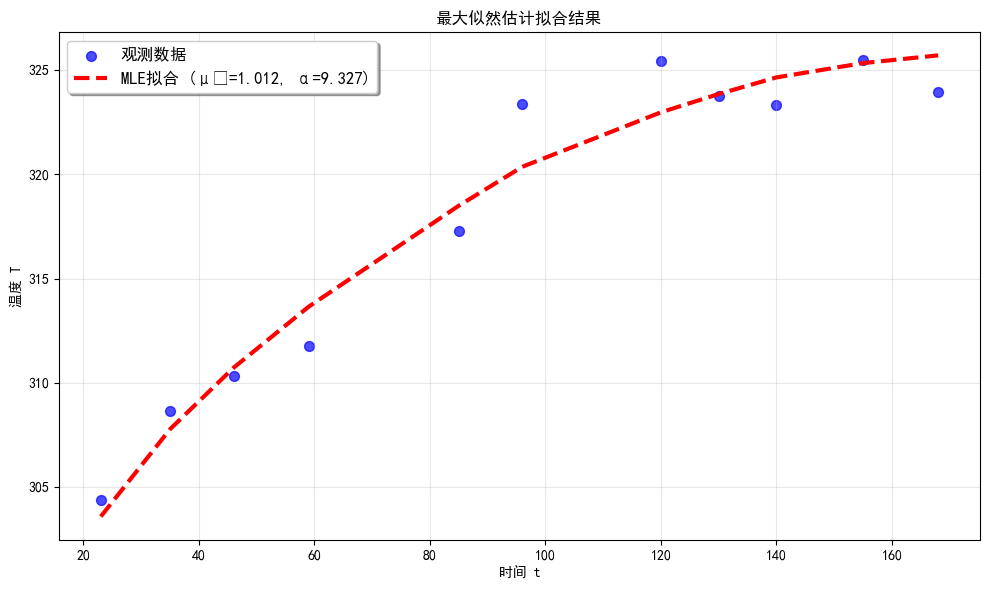

拟合均方误差 (MSE): 2.433664

步骤4: 计算剖面似然
--------------------------------------------------
开始计算剖面似然...
计算μ₂的剖面似然...


μ₂ Profile: 100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


计算α的剖面似然...


α Profile: 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


计算σ(phi)的剖面似然...


σ Profile: 100%|██████████| 50/50 [00:03<00:00, 13.94it/s]


剖面似然计算完成!


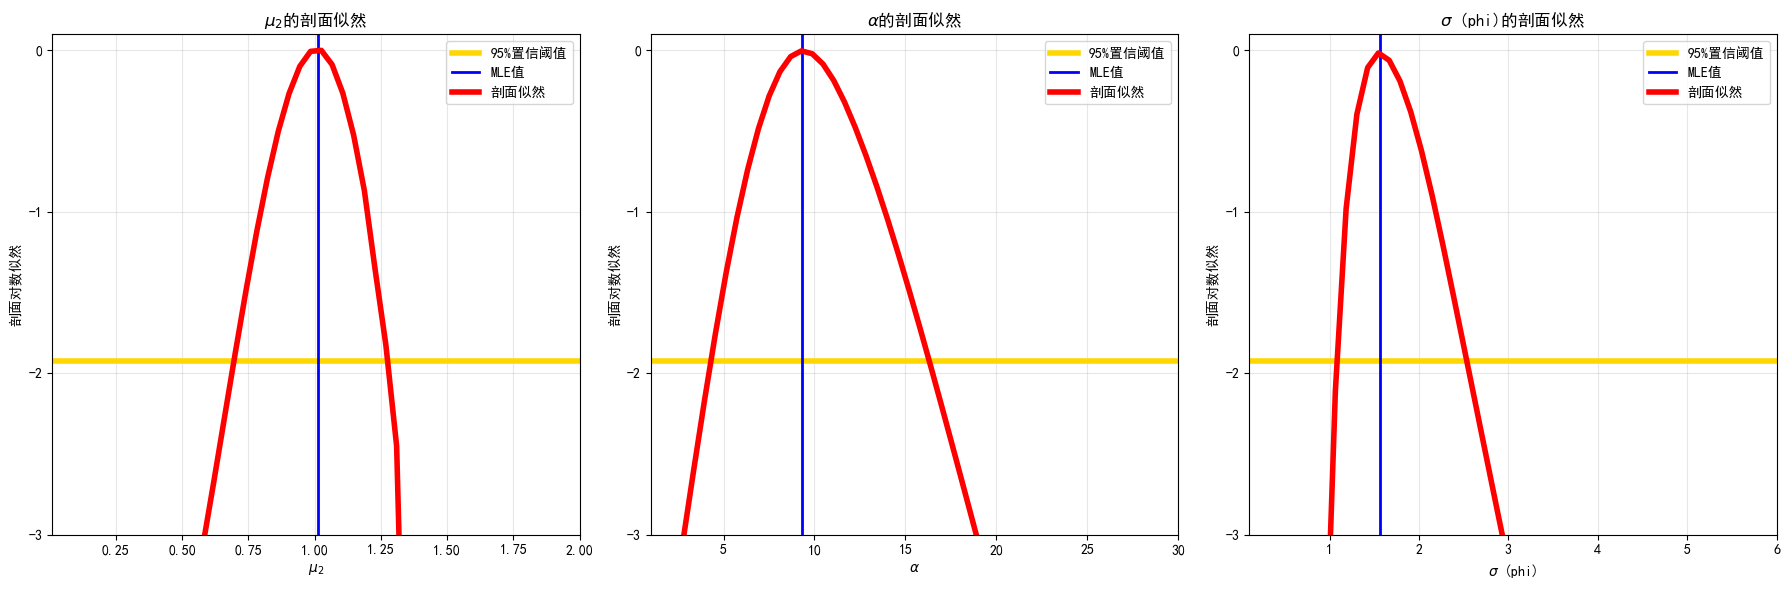


步骤5: 计算参数置信区间
--------------------------------------------------
μ₂的95%置信区间: [0.7004, 1.2690]
α的95%置信区间: [4.5510, 15.7959]
σ(phi)的95%置信区间: [1.1837, 2.5082]

步骤6: 计算预测区间
--------------------------------------------------
计算95.0%预测区间...
   • 使用完整3×3 Fisher矩阵计算参数不确定性
   • 参数协方差矩阵对角元素: diag(Cov) = [0.000082, 0.006020, 0.045553]
   • 平均预测标准差: 1.5680
   • 平均模型不确定性占比: 1.31%


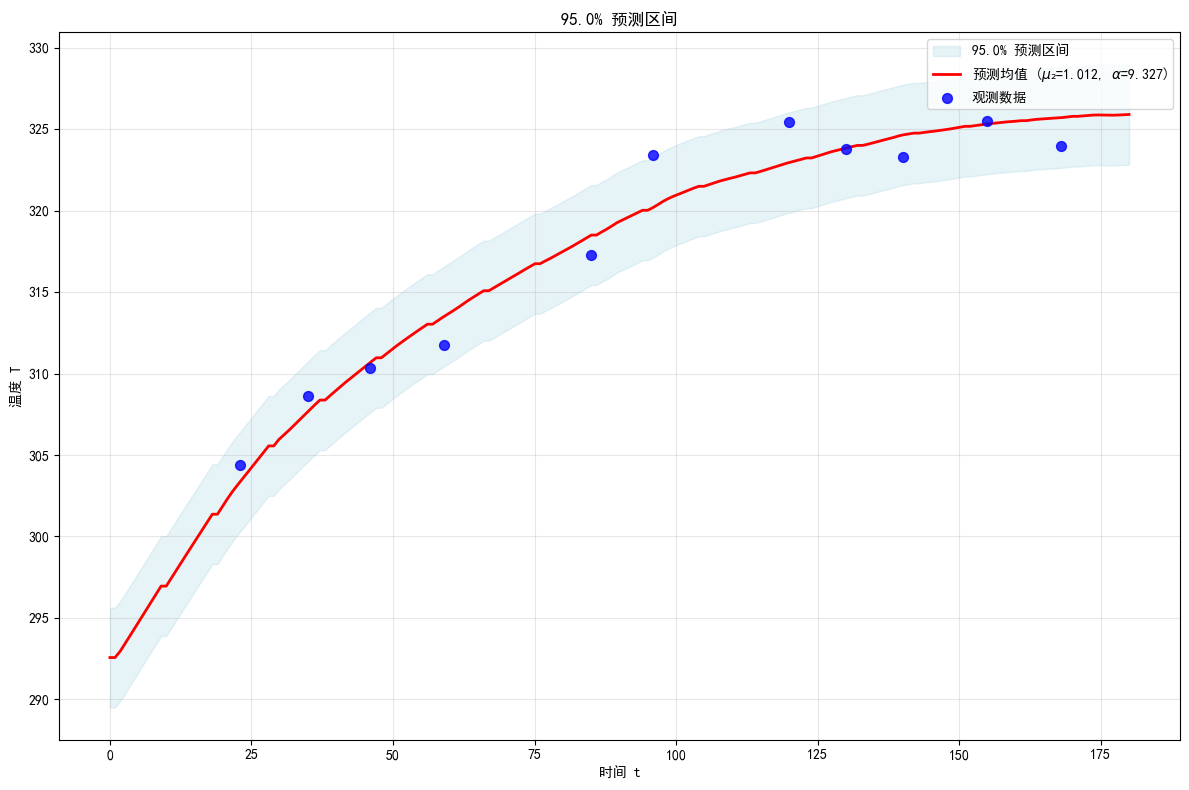

预测区间宽度 (平均): 6.1466
预测标准差 (平均): 1.5680

步骤7: 分析结果总结
--------------------------------------------------
真实参数: μ₂=0.9142, α=10.4100
LOAD估计: μ₂=0.9756, α=9.9764
MLE估计:  μ₂=1.0123, α=9.3273
LOAD误差: |Δμ₂|=0.0614, |Δα|=0.4336
MLE误差:  |Δμ₂|=0.0981, |Δα|=1.0827

分析结果汇总
增强LOAD - MLE结果: μ₂=1.0123, α=9.3273
增强LOAD - 参数误差: |Δμ₂|=0.0981, |Δα|=1.0827
增强LOAD - 对数似然: -20.5000
总体参数误差: 1.1808

分析完成！接下来将生成学术三合一综合图...


In [ ]:
# 运行完整分析流程
print("开始运行完整的LOAD算法 + MLE + 预测区间分析流程...")
print("\n注意：这个流程会依次执行以下步骤：")
print("1. 运行LOAD算法获取最优观测点")
print("2. 基于观测点进行最大似然估计")
print("3. 绘制MLE拟合结果")
print("4. 计算并绘制剖面似然图")
print("5. 计算参数置信区间")
print("6. 计算并绘制预测区间")
print("7. 总结分析结果")

# 运行增强LOAD算法的完整分析  
print("\n" + "="*80)
print("增强LOAD算法完整分析")
results_enhanced = complete_analysis_pipeline(algorithm_type='enhanced', n_total=11, seed=38)

if results_enhanced is not None:
    print("\n" + "="*80)
    print("分析结果汇总")
    print("="*80)
    
    true_params = [0.9142, 10.41]
    mle_enh = results_enhanced['mle_analysis']
    
    # 计算误差
    error_enh = [abs(mle_enh.mu2mle - true_params[0]), abs(mle_enh.alphamle - true_params[1])]
    
    print(f"增强LOAD - MLE结果: μ₂={mle_enh.mu2mle:.4f}, α={mle_enh.alphamle:.4f}")
    print(f"增强LOAD - 参数误差: |Δμ₂|={error_enh[0]:.4f}, |Δα|={error_enh[1]:.4f}")
    print(f"增强LOAD - 对数似然: {mle_enh.fmle:.4f}")
    print(f"总体参数误差: {sum(error_enh):.4f}")
        
print("\n" + "="*80)
print("="*80)

正在生成学术论文风格的综合图...


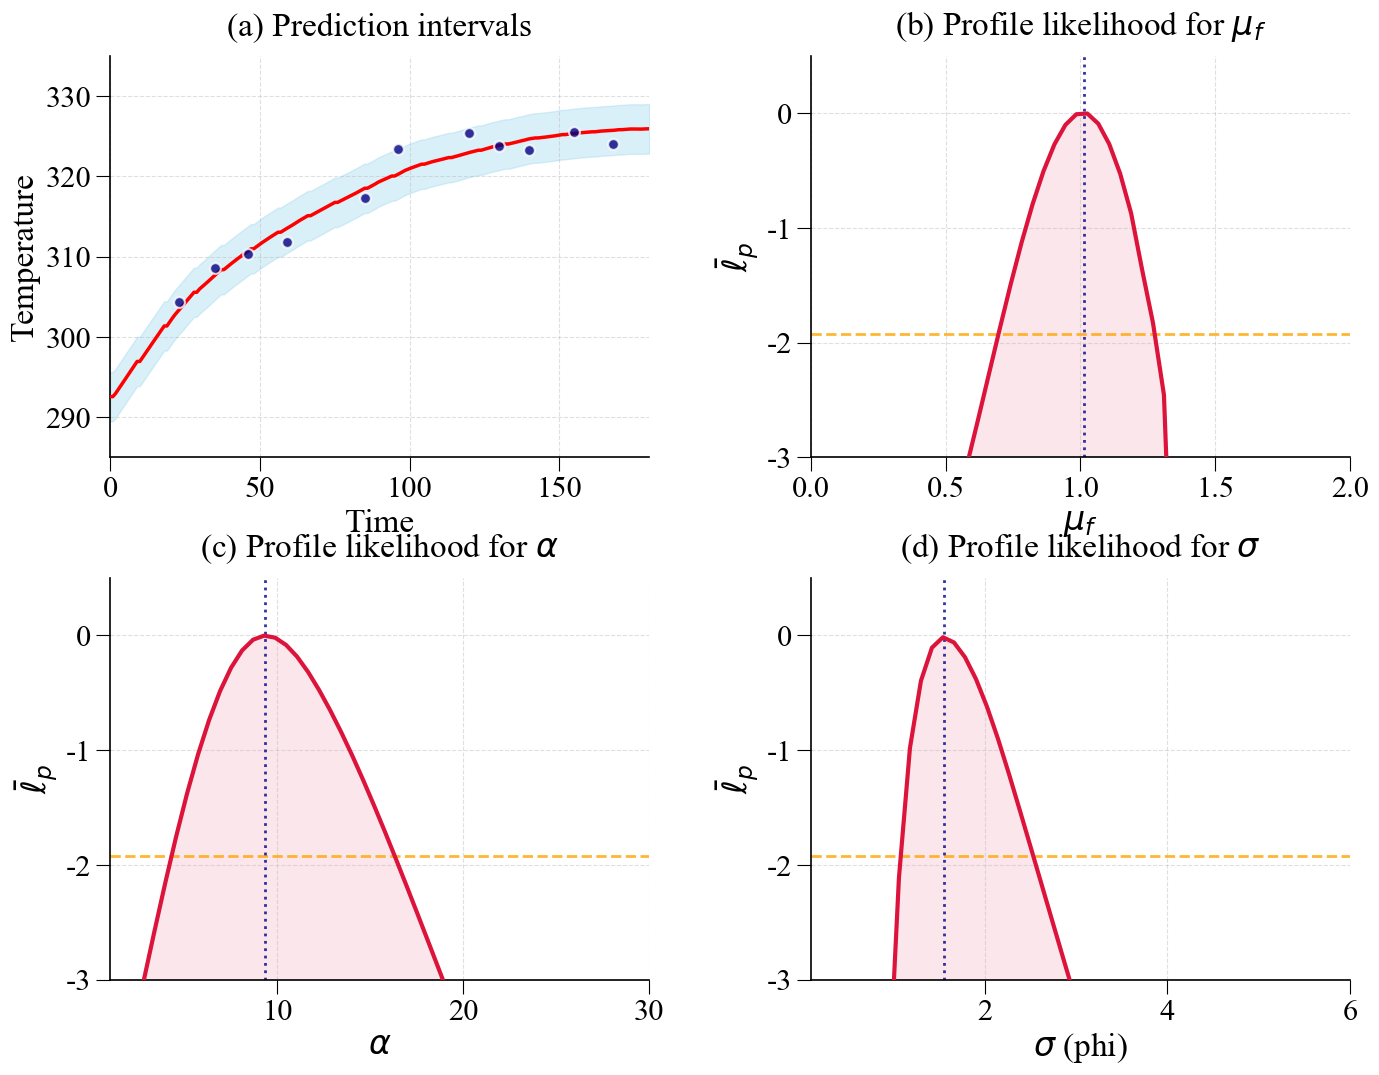

✅ 四合一综合图绘制完成！

图表说明：
  (a) 预测区间图 - 显示MLE拟合曲线、95%预测区间和观测数据
  (b) μ₂剖面似然图 - 显示μ₂参数的不确定性
  (c) α剖面似然图 - 显示α参数的不确定性
  (d) σ(phi)剖面似然图 - 显示噪声标准差的不确定性


In [ ]:
# =====================================================
# 
# =====================================================

# 
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 20,
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.major.size': 10,
    'xtick.minor.size': 6,
    'ytick.major.size': 10,
    'ytick.minor.size': 6,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.framealpha': 0.9,
    'legend.fancybox': True,
    'grid.linewidth': 0.8,
    'lines.linewidth': 2.5,
})

if results_enhanced is not None:
    print("正在生成学术论文风格的综合图...")
    
    
    mle_analysis_enh = results_enhanced['mle_analysis']
    pred_analysis_enh = results_enhanced['pred_analysis']
    t_obs_load, y_obs_load, params_est = results_enhanced['load_results']
    
    
    if not hasattr(mle_analysis_enh, 'ff_mu2') or len(mle_analysis_enh.ff_mu2) < 50:
        print("重新计算更精细的剖面似然网格（M=50）...")
        mle_analysis_enh.compute_profile_likelihood(M=50)
    
    # 
    mu2mle = mle_analysis_enh.mu2mle
    alphamle = mle_analysis_enh.alphamle
    fmle = mle_analysis_enh.fmle
    
    # 
    mu2_range = mle_analysis_enh.mu2range
    alpha_range = mle_analysis_enh.alpharange
    ff_mu2 = mle_analysis_enh.ff_mu2
    ff_alpha = mle_analysis_enh.ff_alpha
    
    # 
    sp3_mu2 = UnivariateSpline(mu2_range, ff_mu2 - fmle, k=3, w=np.ones(len(mu2_range)), s=1/100)
    yy_mu2 = sp3_mu2(mu2_range)
    
    sp3_alpha = UnivariateSpline(alpha_range, ff_alpha - fmle, k=3, w=np.ones(len(alpha_range)), s=1/100)
    yy_alpha = sp3_alpha(alpha_range)
    
    # 
    t_pred = pred_analysis_enh.t_pred
    y_pred = pred_analysis_enh.y_pred
    lower_bound = pred_analysis_enh.lower_bound
    upper_bound = pred_analysis_enh.upper_bound
    
    # 置信水平阈值
    df = 1
    llstar = -stats.chi2.ppf(0.95, df) / 2
    
    # 
    has_sigma_profile = (mle_analysis_enh.estimate_sigma and 
                        hasattr(mle_analysis_enh, 'ff_sigma') and 
                        hasattr(mle_analysis_enh, 'sigma_mle'))
    
    if has_sigma_profile:
        # 2x2
        fig_publication = plt.figure(figsize=(16, 12))
        gs = fig_publication.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
        
        ax1 = fig_publication.add_subplot(gs[0, 0])  
        ax2 = fig_publication.add_subplot(gs[0, 1])  
        ax3 = fig_publication.add_subplot(gs[1, 0])  
        ax4 = fig_publication.add_subplot(gs[1, 1])  
        
        # sigma
        sigma_range = mle_analysis_enh.sigmarange
        ff_sigma = mle_analysis_enh.ff_sigma
        sigma_mle = mle_analysis_enh.sigma_mle
        
        sp3_sigma = UnivariateSpline(sigma_range, ff_sigma - fmle, k=3, 
                                     w=np.ones(len(sigma_range)), s=1/100)
        yy_sigma = sp3_sigma(sigma_range)
    else:
        # 创建三合一综合图（1x3布局）
        fig_publication, axes = plt.subplots(1, 3, figsize=(15, 5))
        ax1, ax2, ax3 = axes[0], axes[1], axes[2]
    
    # =====================================================
    # 1
    # =====================================================
    ax1.fill_between(t_pred, lower_bound, upper_bound, color='skyblue', alpha=0.3, 
                    label='95% Prediction interval', zorder=1)
    
    # MLE
    ax1.plot(t_pred, y_pred, 'r-', linewidth=2.5, label='MLE prediction', zorder=3)
    
    # 观测数据点
    ax1.scatter(t_obs_load, y_obs_load, color='navy', s=60, zorder=4, label='Observed data', 
               edgecolors='white', linewidth=1.5, alpha=0.8)
    
    ax1.set_xlabel('Time', fontsize=24)
    ax1.set_ylabel('Temperature', fontsize=24)
    ax1.set_xlim(0, tmax)
    ax1.set_ylim(285, 335)
    ax1.tick_params(labelsize=22)
    # ax1.legend(fontsize=17, loc='lower right', frameon=True)
    ax1.grid(True, alpha=0.4, linestyle='--')
    ax1.set_title('(a) Prediction intervals', fontsize=24, pad=15)
    
    # =====================================================
    # 2：μ₂
    # =====================================================
    ax2.axhline(y=llstar, color='orange', linestyle='--', linewidth=2, label='95% threshold', alpha=0.8)
    ax2.axvline(x=mu2mle, color='darkblue', linestyle=':', linewidth=2, label='MLE', alpha=0.8)
    ax2.plot(mu2_range, yy_mu2, 'crimson', linewidth=3, label='Profile likelihood', zorder=3)
    ax2.fill_between(mu2_range, yy_mu2, -3, alpha=0.1, color='crimson')
    
    ax2.set_ylim(-3, 0.5)
    ax2.set_xlim(0, 2)  
    ax2.set_xlabel(r'$\mu_f$', fontsize=24)
    ax2.set_ylabel(r'$\bar{\ell}_p$', fontsize=24)
    ax2.tick_params(labelsize=22)
    # ax2.legend(fontsize=16, loc='upper right', frameon=True)
    ax2.grid(True, alpha=0.4, linestyle='--')
    ax2.set_title(r'(b) Profile likelihood for $\mu_f$', fontsize=24, pad=15)
    
    # =====================================================
    # 3：α
    # =====================================================
    ax3.axhline(y=llstar, color='orange', linestyle='--', linewidth=2, label='95% threshold', alpha=0.8)
    ax3.axvline(x=alphamle, color='darkblue', linestyle=':', linewidth=2, label='MLE', alpha=0.8)
    ax3.plot(alpha_range, yy_alpha, 'crimson', linewidth=3, label='Profile likelihood', zorder=3)
    ax3.fill_between(alpha_range, yy_alpha, -3, alpha=0.1, color='crimson')
    
    ax3.set_ylim(-3, 0.5)
    ax3.set_xlim(1, 30)
    ax3.set_xlabel(r'$\alpha$', fontsize=24)
    ax3.set_ylabel(r'$\bar{\ell}_p$', fontsize=24)
    ax3.tick_params(labelsize=22)
    # ax3.legend(fontsize=16, loc='upper right', frameon=True)
    ax3.grid(True, alpha=0.4, linestyle='--')
    ax3.set_title(r'(c) Profile likelihood for $\alpha$', fontsize=24, pad=15)
    
    # =====================================================
    # 4：σ(phi)
    # =====================================================
    if has_sigma_profile:
        ax4.axhline(y=llstar, color='orange', linestyle='--', linewidth=2, label='95% threshold', alpha=0.8)
        ax4.axvline(x=sigma_mle, color='darkblue', linestyle=':', linewidth=2, label='MLE', alpha=0.8)
        ax4.plot(sigma_range, yy_sigma, 'crimson', linewidth=3, label='Profile likelihood', zorder=3)
        ax4.fill_between(sigma_range, yy_sigma, -3, alpha=0.1, color='crimson')
        
        ax4.set_ylim(-3, 0.5)
        ax4.set_xlim(sigma_range[0], sigma_range[-1])
        ax4.set_xlabel(r'$\sigma$ (phi)', fontsize=24)
        ax4.set_ylabel(r'$\bar{\ell}_p$', fontsize=24)
        ax4.tick_params(labelsize=22)
        # ax4.legend(fontsize=16, loc='upper right', frameon=True)
        ax4.grid(True, alpha=0.4, linestyle='--')
        ax4.set_title(r'(d) Profile likelihood for $\sigma$', fontsize=24, pad=15)
    
    # 调整布局
    plt.tight_layout()
    if not has_sigma_profile:
        plt.subplots_adjust(wspace=0.3)
    
    # 显示图表
    plt.show()
    
    if has_sigma_profile:
        print("✅ 四合一综合图绘制完成！")
        print("\n图表说明：")
        print("  (a) 预测区间图 - 显示MLE拟合曲线、95%预测区间和观测数据")
        print("  (b) μ₂剖面似然图 - 显示μ₂参数的不确定性")
        print("  (c) α剖面似然图 - 显示α参数的不确定性")
        print("  (d) σ(phi)剖面似然图 - 显示噪声标准差的不确定性")
    else:
        print("✅ 三合一综合图绘制完成！")
        print("\n图表说明：")
        print("  (a) 预测区间图 - 显示MLE拟合曲线、95%预测区间和观测数据")
        print("  (b) μ₂剖面似然图 - 显示μ₂参数的不确定性")
        print("  (c) α剖面似然图 - 显示α参数的不确定性")
else:
    print("❌ 未找到分析结果，请先运行完整分析流程（上一个单元格）")


Font 'default' does not have a glyph for '\u566a' [U+566a], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u58f0' [U+58f0], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6807' [U+6807], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u51c6' [U+51c6], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5dee' [U+5dee], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5256' [U+5256], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u9762' [U+9762], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5bf9' [U+5bf9], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u6570' [U+6570], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u4f3c' [U+4f3c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u7136' [U+7136], 

σ(phi)参数的剖面似然分析结果

✅ σ(phi)的MLE估计值: 1.5617
✅ σ(phi)的95%置信区间: [1.1837, 2.5082]
✅ 置信区间宽度: 1.3245
✅ 真实值 phi = 2.0 在置信区间内


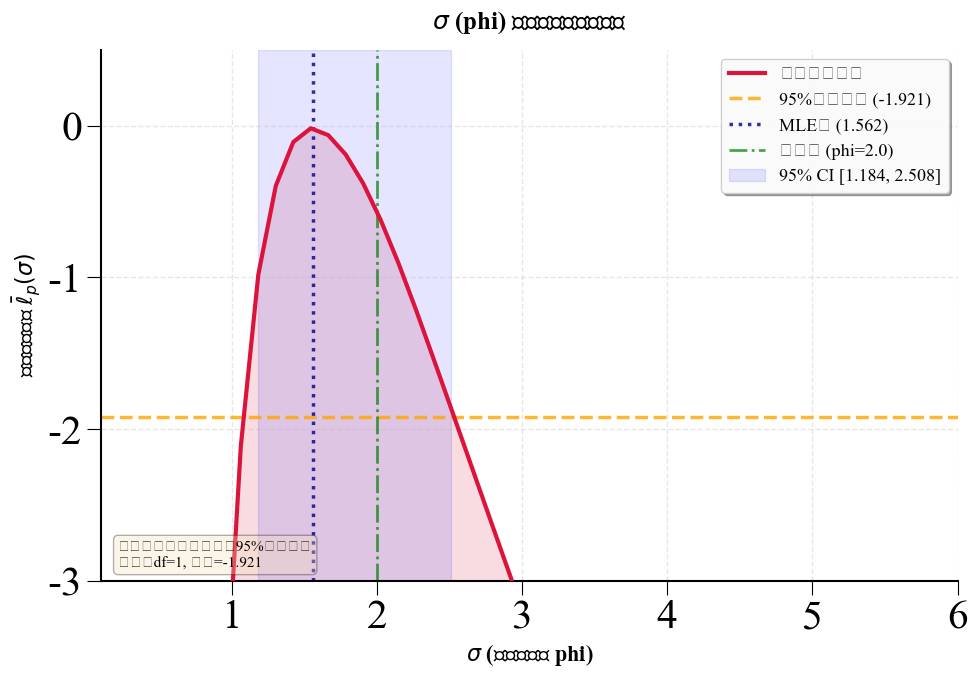


额外统计信息
参数范围: [0.100, 6.000]
网格点数: 50
最大对数似然值: -20.5000
相对误差 (MLE vs 真实值): 21.91%
置信区间相对宽度: 84.81% (相对于MLE值)


In [9]:
# =====================================================
# σ(phi)参数的详细剖面似然分析和可视化
# =====================================================

if results_enhanced is not None:
    mle_analysis_enh = results_enhanced['mle_analysis']
    
    # 检查是否估计了sigma并计算了剖面似然
    if mle_analysis_enh.estimate_sigma and hasattr(mle_analysis_enh, 'ff_sigma'):
        print("=" * 60)
        print("σ(phi)参数的剖面似然分析结果")
        print("=" * 60)
        
        # 获取数据
        sigma_range = mle_analysis_enh.sigmarange
        ff_sigma = mle_analysis_enh.ff_sigma
        sigma_mle = mle_analysis_enh.sigma_mle
        fmle = mle_analysis_enh.fmle
        
        # 计算置信区间
        df = 1
        llstar = -stats.chi2.ppf(0.95, df) / 2
        ratio_sigma = ff_sigma - fmle
        indices_sigma = np.where(ratio_sigma >= llstar)[0]
        
        if len(indices_sigma) > 0:
            sigma_ci_lower = sigma_range[indices_sigma[0]]
            sigma_ci_upper = sigma_range[indices_sigma[-1]]
            print(f"\n✅ σ(phi)的MLE估计值: {sigma_mle:.4f}")
            print(f"✅ σ(phi)的95%置信区间: [{sigma_ci_lower:.4f}, {sigma_ci_upper:.4f}]")
            print(f"✅ 置信区间宽度: {sigma_ci_upper - sigma_ci_lower:.4f}")
            print(f"✅ 真实值 phi = 2.0 {'在' if sigma_ci_lower <= 2.0 <= sigma_ci_upper else '不在'}置信区间内")
        else:
            print("\n⚠️ 未找到σ(phi)的置信区间，请检查参数范围")
            sigma_ci_lower, sigma_ci_upper = None, None
        
        # 绘制详细的剖面似然图
        plt.rcParams.update({
            'font.family': 'Times New Roman',
            'font.size': 14,
            'axes.linewidth': 1.5,
        })
        
        fig, ax = plt.subplots(figsize=(10, 7))
        
        # 使用样条插值平滑曲线
        sp_sigma = UnivariateSpline(sigma_range, ff_sigma - fmle, k=3, 
                                    w=np.ones(len(sigma_range)), s=1/100)
        yy_sigma = sp_sigma(sigma_range)
        
        # 绘制剖面似然曲线
        ax.plot(sigma_range, yy_sigma, linewidth=3, color='crimson', 
               label='剖面似然曲线', zorder=3)
        ax.fill_between(sigma_range, yy_sigma, -3, alpha=0.15, color='crimson')
        
        # 添加95%置信阈值线
        ax.axhline(y=llstar, color='orange', linestyle='--', linewidth=2.5, 
                  label=f'95%置信阈值 ({llstar:.3f})', alpha=0.8, zorder=2)
        
        # 添加MLE垂直线
        ax.axvline(x=sigma_mle, color='darkblue', linestyle=':', linewidth=2.5, 
                  label=f'MLE值 ({sigma_mle:.3f})', alpha=0.8, zorder=2)
        
        # 如果真实值在范围内，添加真实值线
        if sigma_range[0] <= 2.0 <= sigma_range[-1]:
            ax.axvline(x=2.0, color='green', linestyle='-.', linewidth=2, 
                      label='真实值 (phi=2.0)', alpha=0.7, zorder=2)
        
        # 标注置信区间
        if sigma_ci_lower is not None and sigma_ci_upper is not None:
            ax.axvspan(sigma_ci_lower, sigma_ci_upper, alpha=0.1, color='blue', 
                      label=f'95% CI [{sigma_ci_lower:.3f}, {sigma_ci_upper:.3f}]', zorder=1)
        
        # 设置坐标轴
        ax.set_ylim(-3, 0.5)
        ax.set_xlim(sigma_range[0], sigma_range[-1])
        ax.set_xlabel(r'$\sigma$ (噪声标准差 phi)', fontsize=16, fontweight='bold')
        ax.set_ylabel(r'剖面对数似然 $\bar{\ell}_p(\sigma)$', fontsize=16, fontweight='bold')
        ax.set_title(r'$\sigma$ (phi) 参数的剖面似然分析', fontsize=18, fontweight='bold', pad=15)
        
        # 图例和网格
        ax.legend(fontsize=13, loc='upper right', frameon=True, shadow=True, 
                 fancybox=True, framealpha=0.95)
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)
        
        # 添加注释
        ax.text(0.02, 0.02, 
               f'注：基于似然比检验的95%置信区间\n自由度df={df}, 阈值={llstar:.3f}',
               transform=ax.transAxes, fontsize=11, 
               verticalalignment='bottom', bbox=dict(boxstyle='round', 
               facecolor='wheat', alpha=0.3))
        
        plt.tight_layout()
        plt.show()
        
        # 额外的统计信息
        print("\n" + "=" * 60)
        print("额外统计信息")
        print("=" * 60)
        print(f"参数范围: [{sigma_range[0]:.3f}, {sigma_range[-1]:.3f}]")
        print(f"网格点数: {len(sigma_range)}")
        print(f"最大对数似然值: {fmle:.4f}")
        print(f"相对误差 (MLE vs 真实值): {abs(sigma_mle - 2.0) / 2.0 * 100:.2f}%")
        
        if sigma_ci_lower is not None and sigma_ci_upper is not None:
            ci_width_percent = (sigma_ci_upper - sigma_ci_lower) / sigma_mle * 100
            print(f"置信区间相对宽度: {ci_width_percent:.2f}% (相对于MLE值)")
        
    else:
        print("⚠️ 未启用sigma估计或未计算剖面似然")
        print("请确保在MLEAnalysis初始化时设置estimate_sigma=True")
        print("并且已运行compute_profile_likelihood()方法")
else:
    print("❌ 未找到分析结果，请先运行完整分析流程")
